In [1]:
from skimage import morphology as mo
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from skimage.morphology import skeletonize , medial_axis
from skimage.util import invert
from scipy import ndimage as ndi
import cv2 as cv

In [2]:
import numpy as np
from scipy.ndimage import label, center_of_mass

def chebyshev_distance(p1, p2):
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))

def merge_close_pixels(image, k):
    binary_image = (image > 0).astype(np.uint8)  # Convertir a binario
    labeled, num_features = label(binary_image)  # Etiquetar componentes conectados
    
    pixel_groups = []
    trifurcacion = []
    for i in range(1, num_features + 1):
        pixels = np.column_stack(np.where(labeled == i))  # Extraer píxeles del componente
        merged = False
        
        for group in pixel_groups:
            if any(chebyshev_distance(p, pixels[0]) <= k for p in group):
                group.extend(pixels.tolist())
                merged = True
                break
        
        if not merged:
            pixel_groups.append(pixels.tolist())
    
    new_image = np.zeros_like(image)
    for group in pixel_groups:
        centroid = np.round(np.mean(group, axis=0)).astype(int)
        new_image[tuple(centroid)] = 255  # Marcar píxel blanco
    
    return new_image


In [3]:
S1 = np.array((
        [ 0,-1, 0],
        [ 1, 1, 1],
        [-1, 1,-1]), dtype="int")
S2 = np.array((
        [0, -1, 1],
        [1, 1, -1],
        [-1, 1, 0]), dtype="int")

S3 = np.array((
        [ 0,-1, 1],
        [ 1, 1,-1],
        [ 0,-1, 1]), dtype="int") 
S4 = np.array((
        [-1,-1, 1],
        [-1, 1,-1],
        [ 1,-1, 1]), dtype="int") 
S1f = np.array((
        [-1,-1,-1],
        [ 1, 1,-1],
        [-1,-1,-1]), dtype="int")
S2f = np.array((
        [-1,-1, 1],
        [-1, 1,-1],
        [-1,-1,-1]), dtype="int")
S1t = np.array((
        [1,-1, 1],
        [0, 1, 0],
        [1, 0, 1]), dtype="int")
S2t = np.array((
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]), dtype="int")
S3t = np.array((
        [0, 1, 0],
        [0, 1, 1],
        [1, 1, 0],
        [0, 1, 0]), dtype="int")
S4t = np.array((
        [0, 1, 0, 0],
        [1, 1, 0, 0],
        [0, 0, 1, 1],
        [0, 0 ,1, 0]), dtype="int")
S5t = np.array((
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 1],
        [0, 1, 0]), dtype="int")





def detector(I,S):
    I = I.astype(np.uint8)
    H = I[:,:] *0
    for i in range(4):
        S = np.rot90(S)
        H = H + cv.morphologyEx(I, cv.MORPH_HITMISS, S)
    return H
        

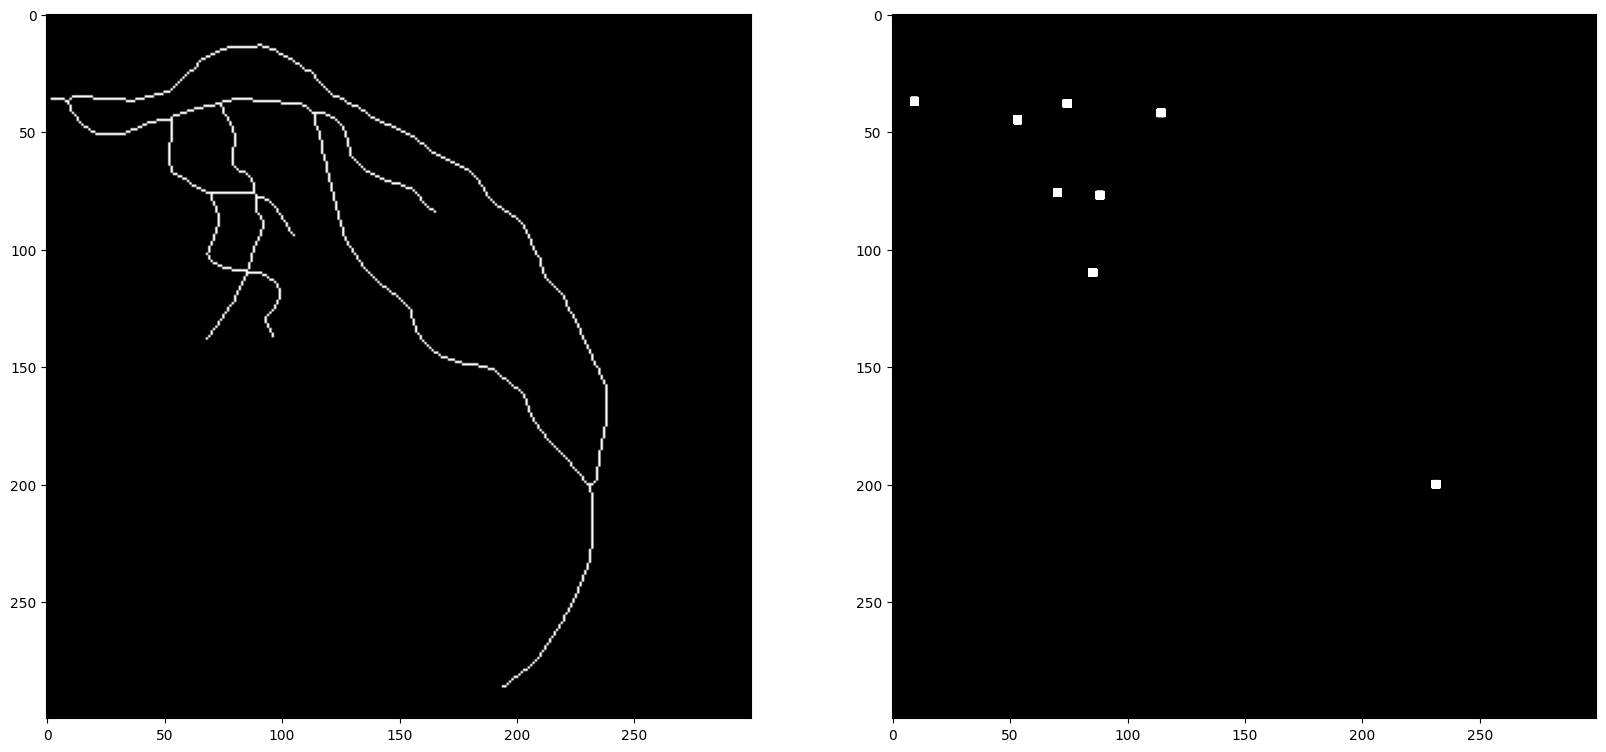

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
I = plt.imread('./2_gt.pgm')
I = I/255
#I = (ski.color.rgb2gray(I* 255)).astype(np.uint8)
T = skeletonize(I)

H = detector(T,S1) + detector(T,S2) + detector(T,S3) + detector(T, S4)
H2 = merge_close_pixels(H, 4)
se3  = mo.rectangle(3,3)
H2 = mo.dilation(H2, se3)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1) 
plt.imshow(T,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,2,2)                                 
plt.imshow(H2,cmap='gray', vmin=0, vmax=1)
plt.show()
print(H)

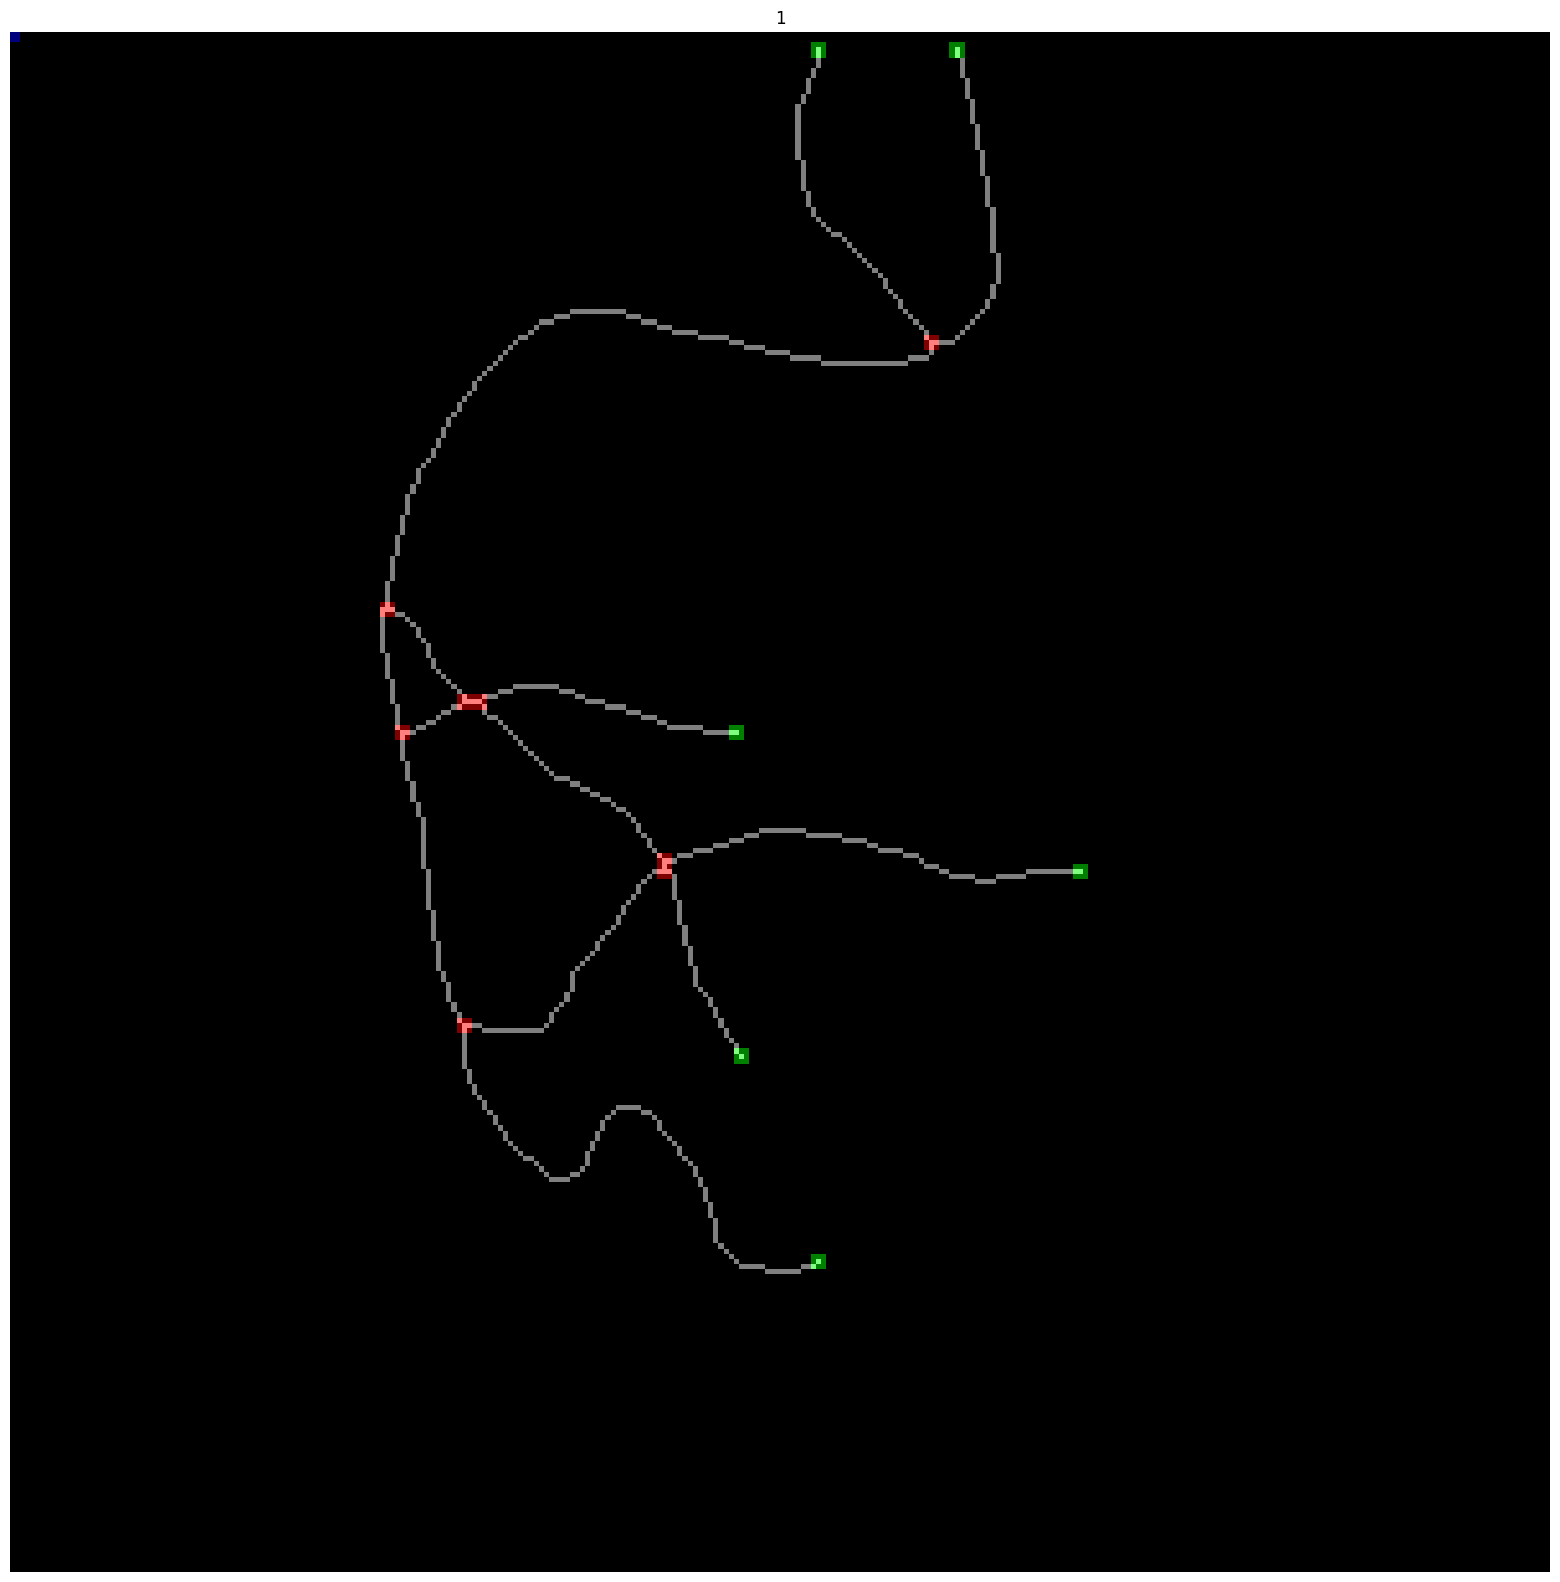

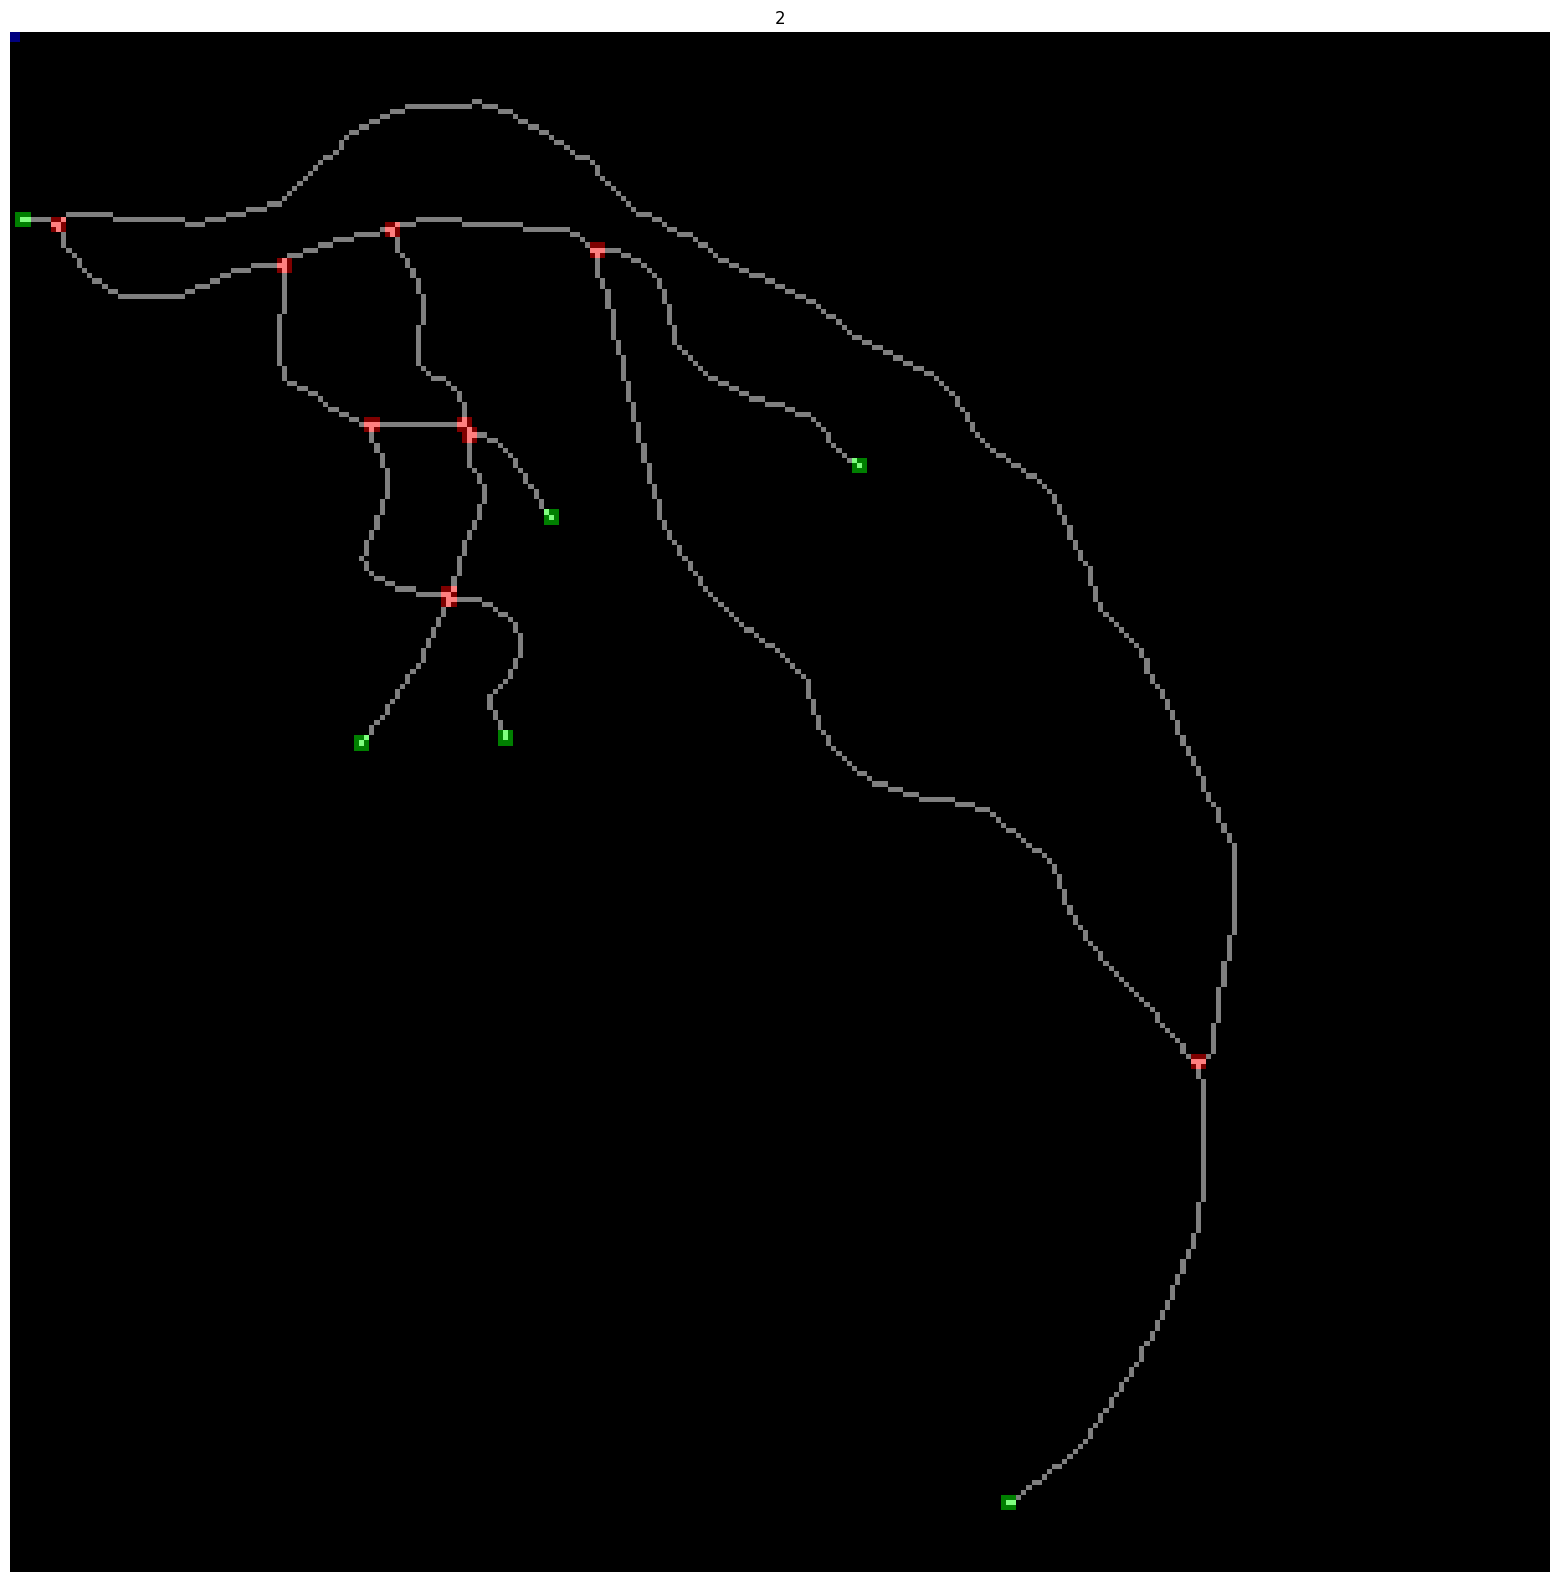

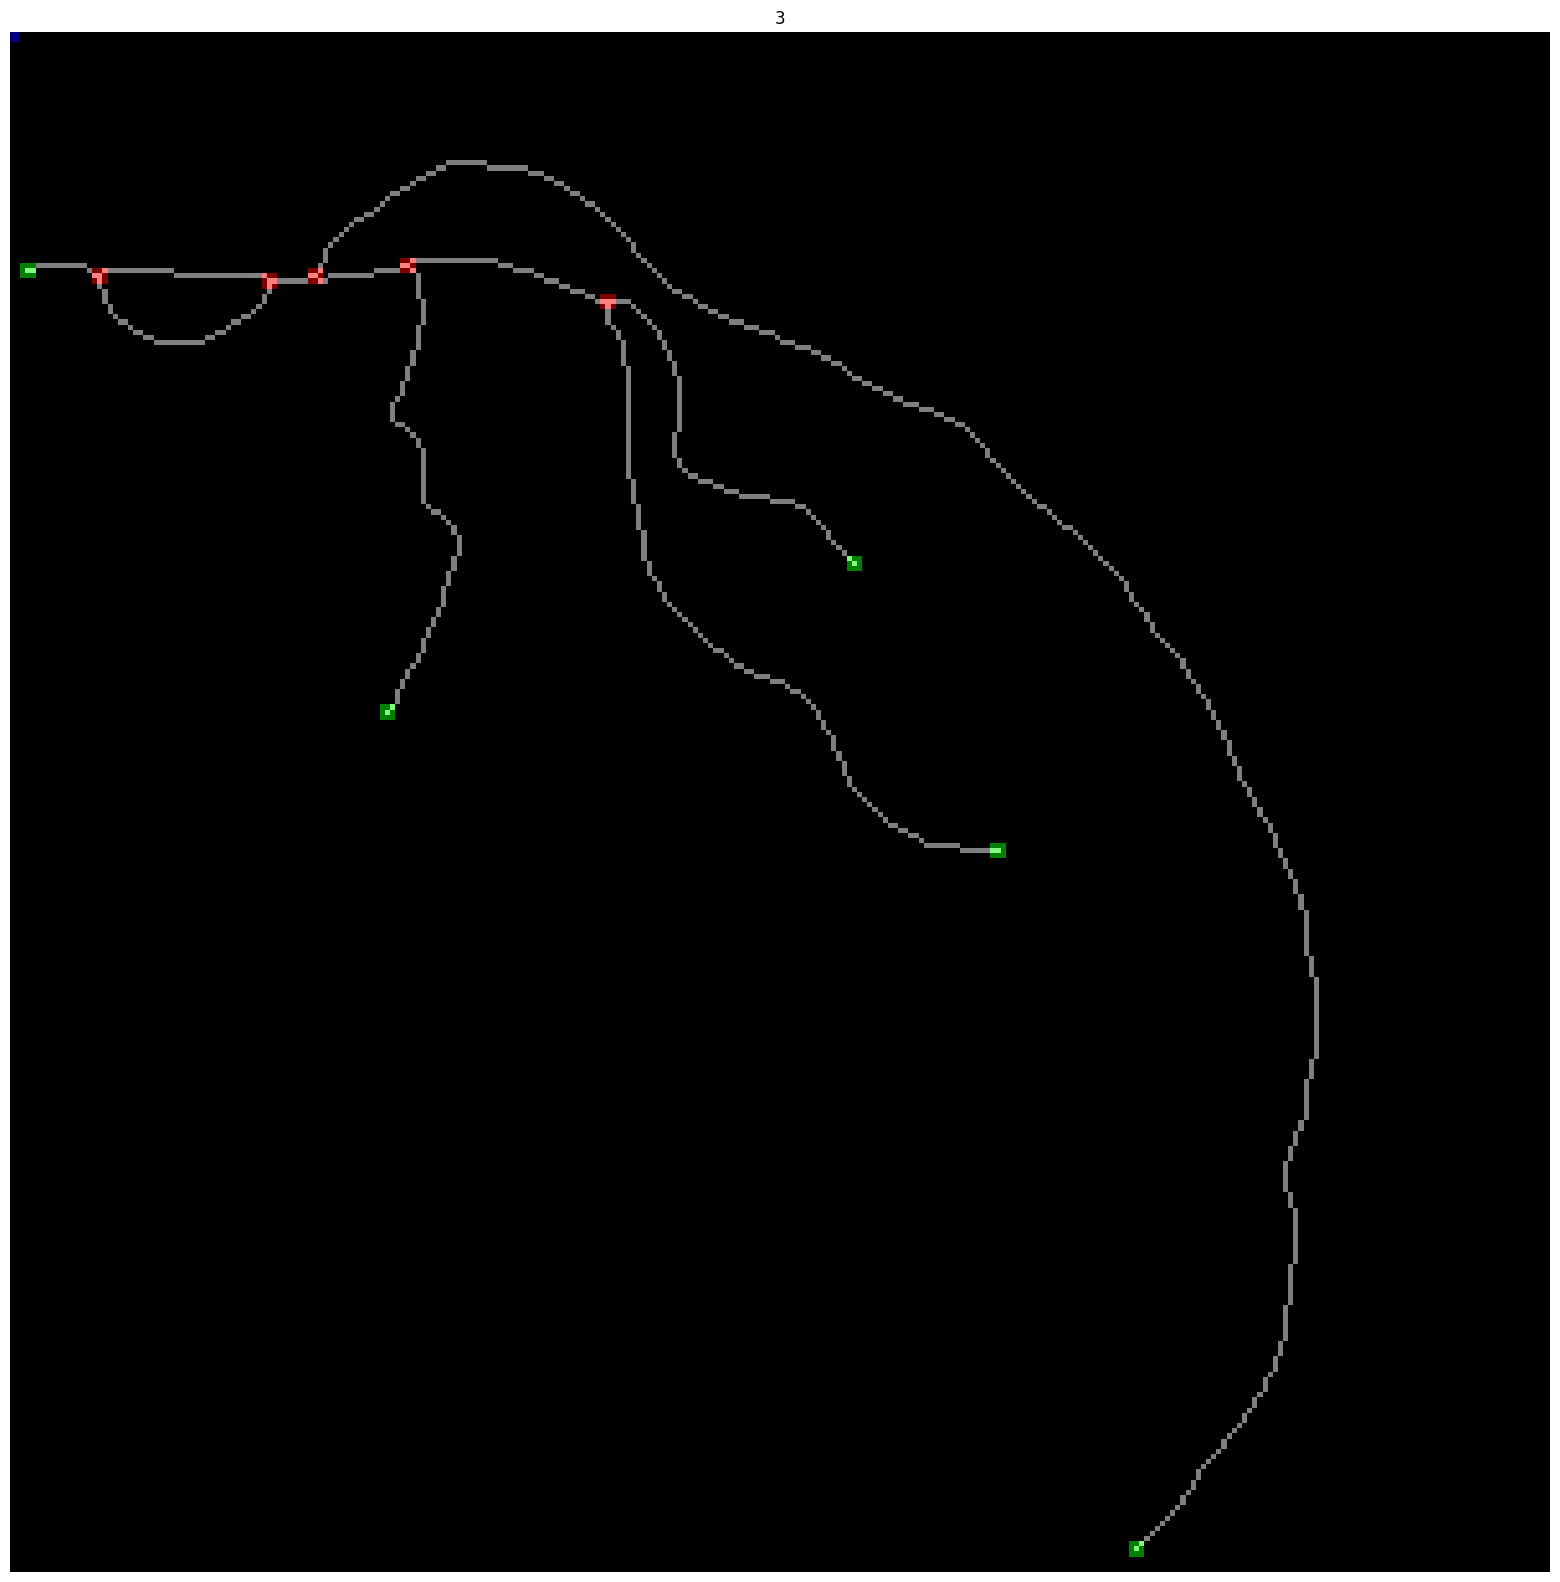

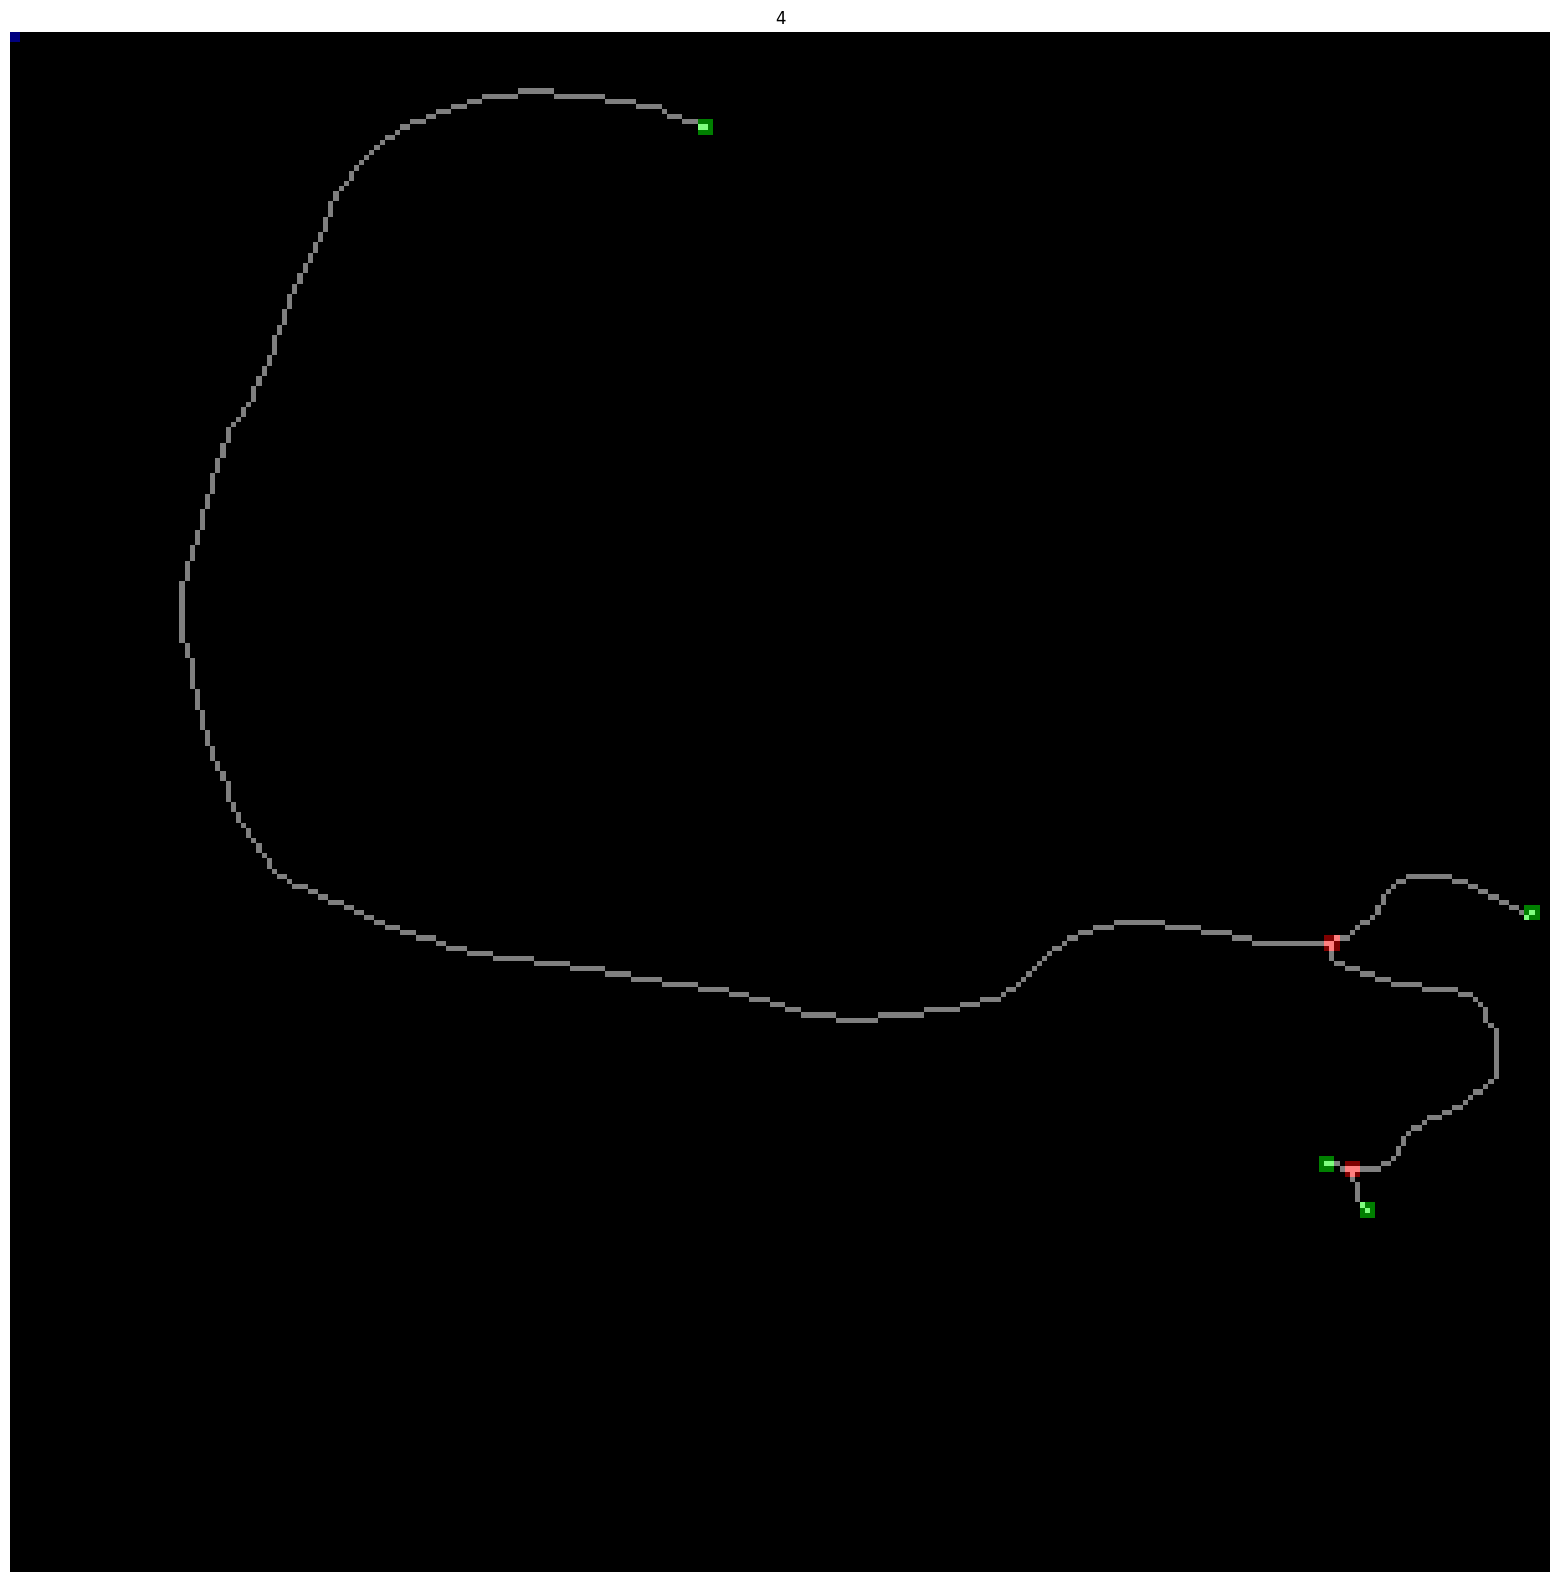

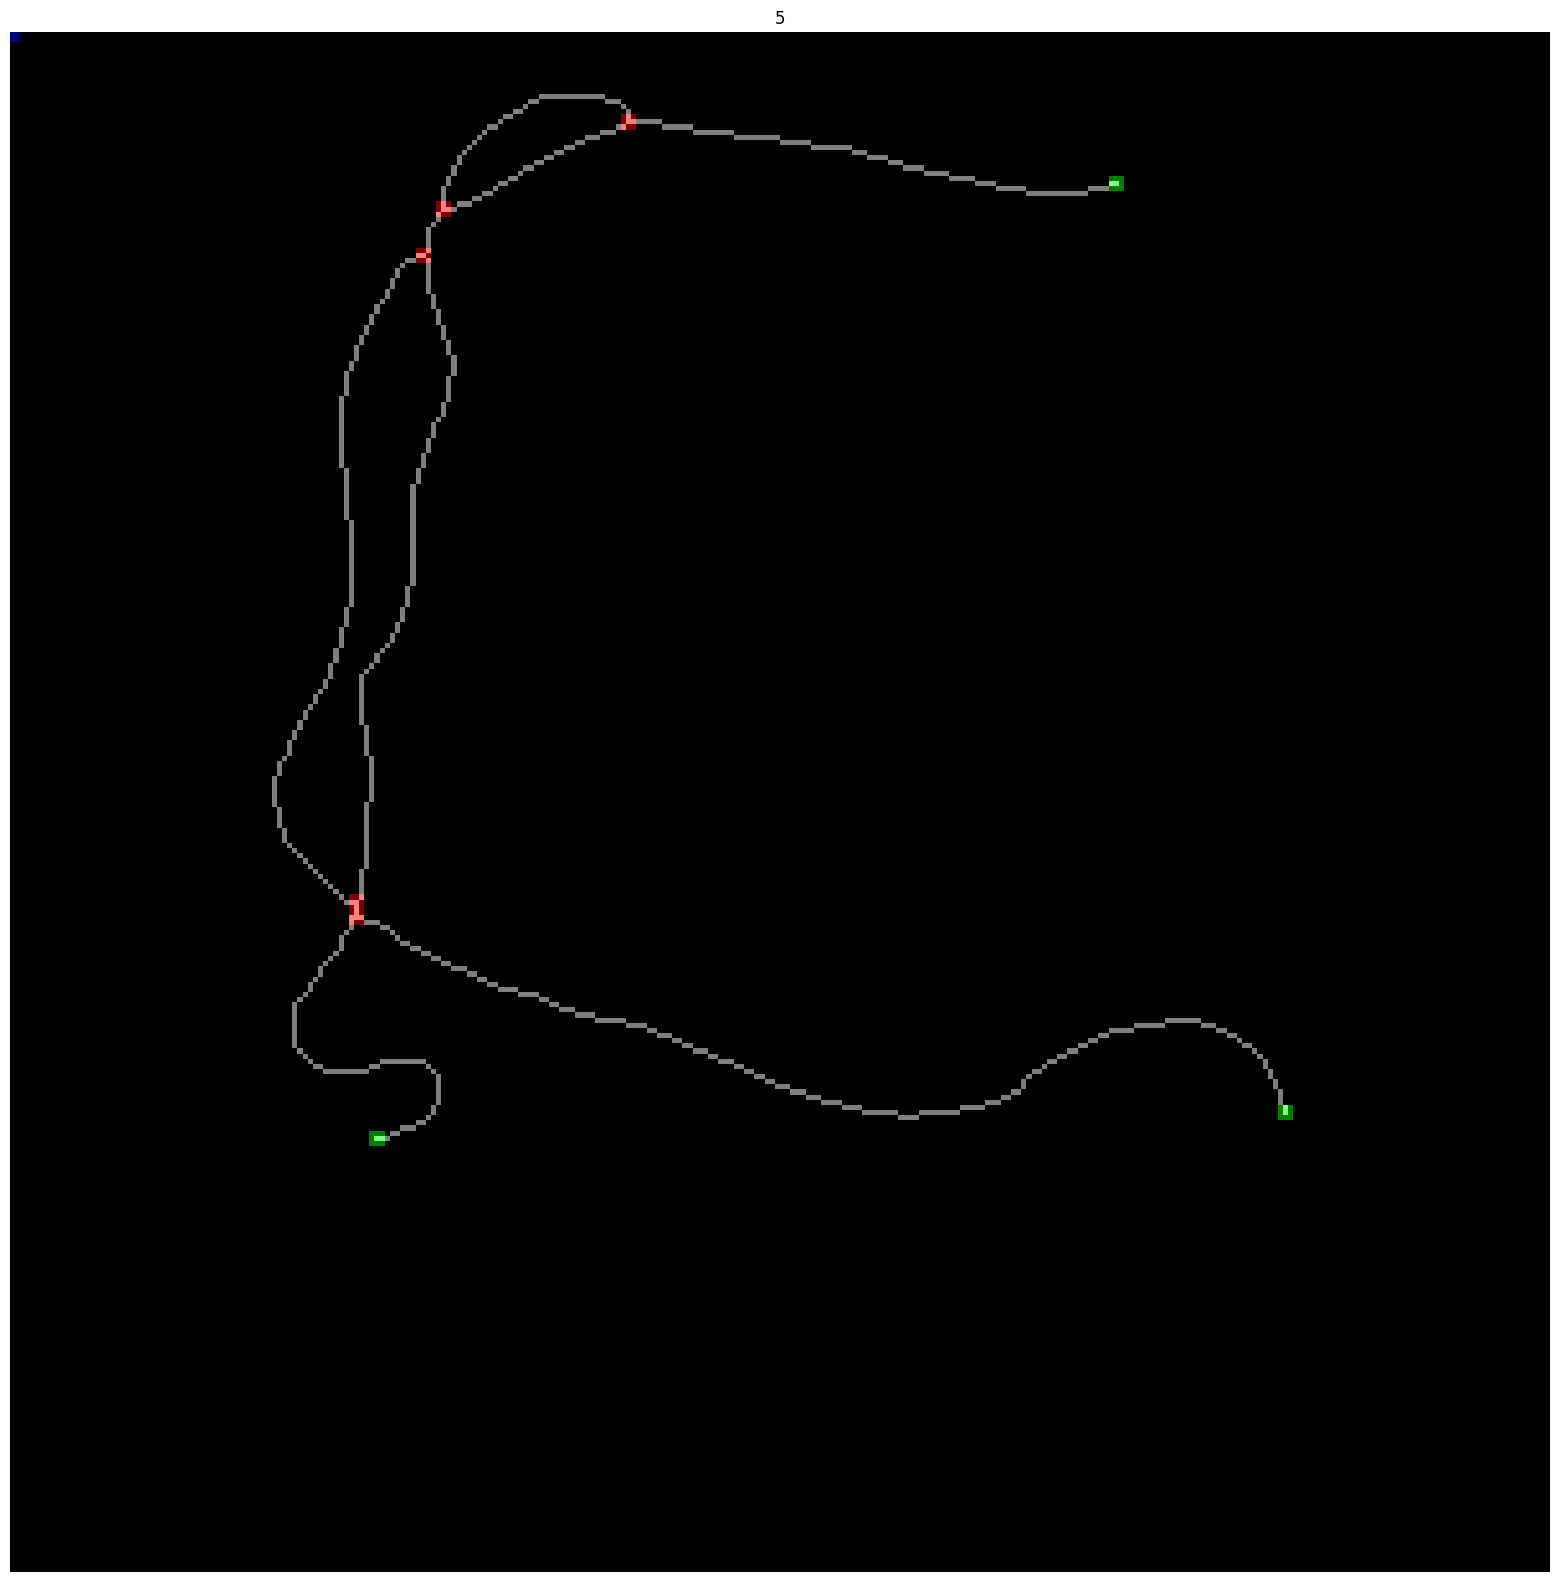

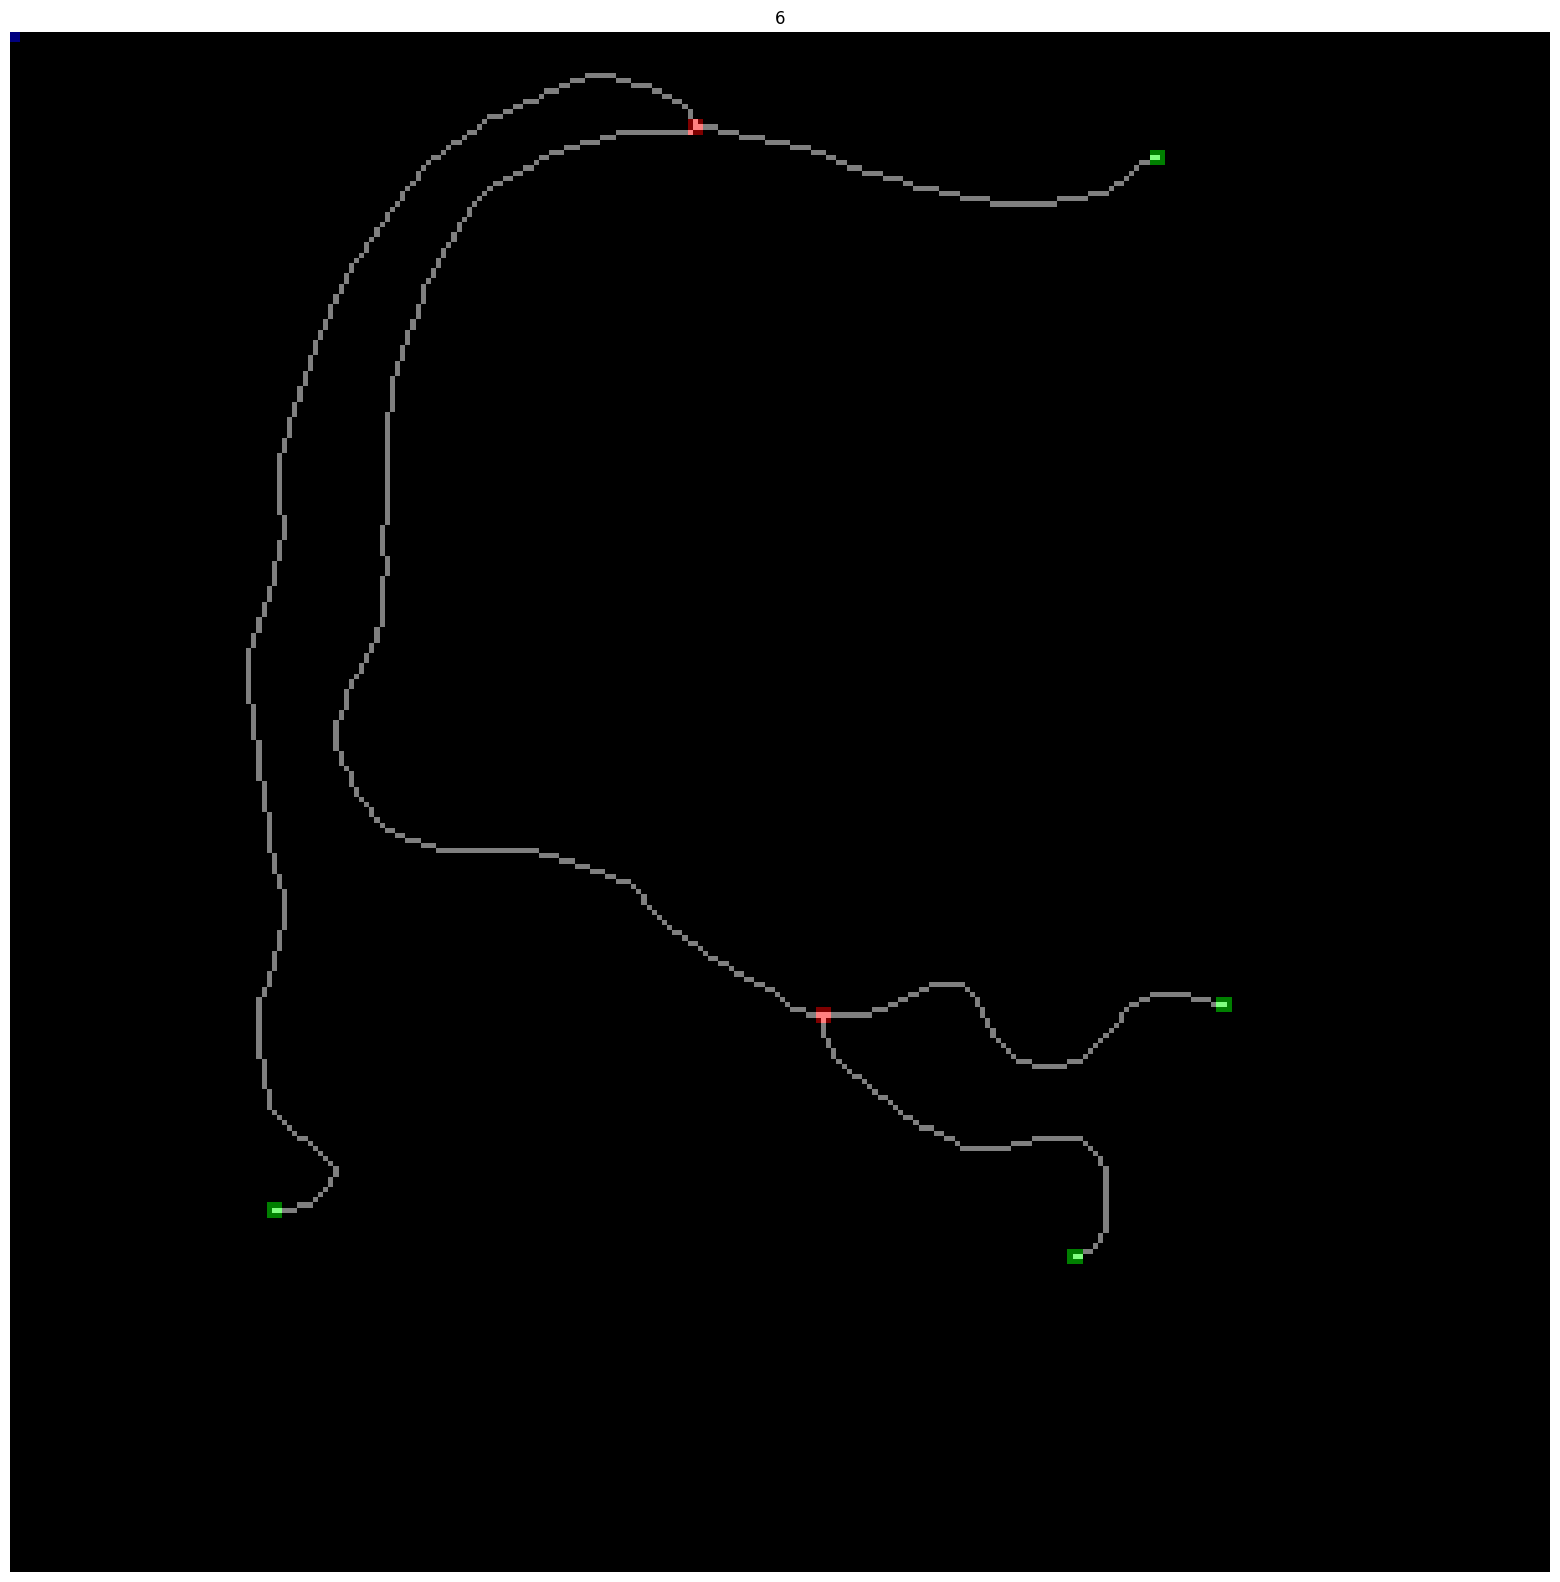

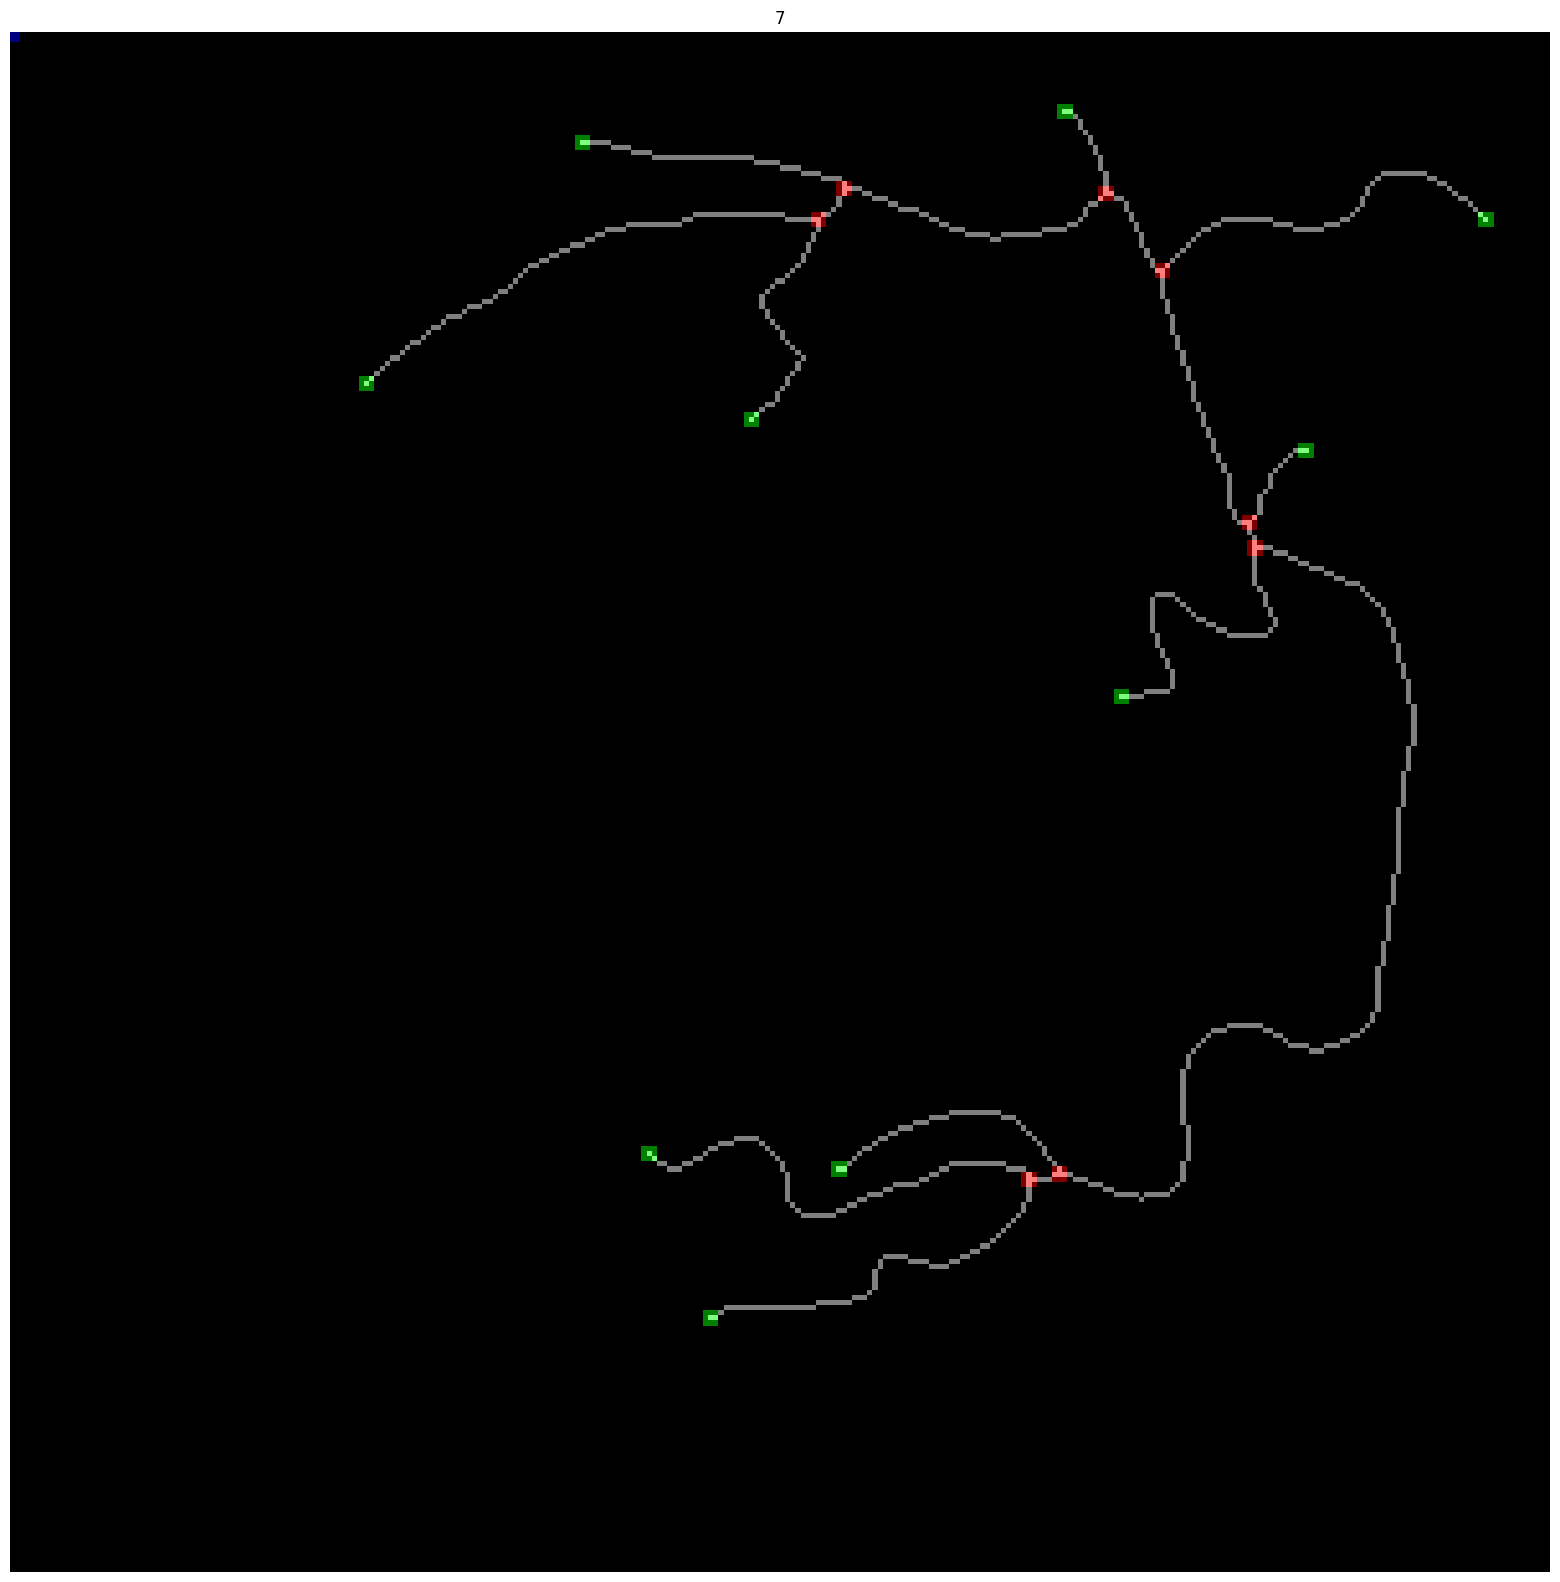

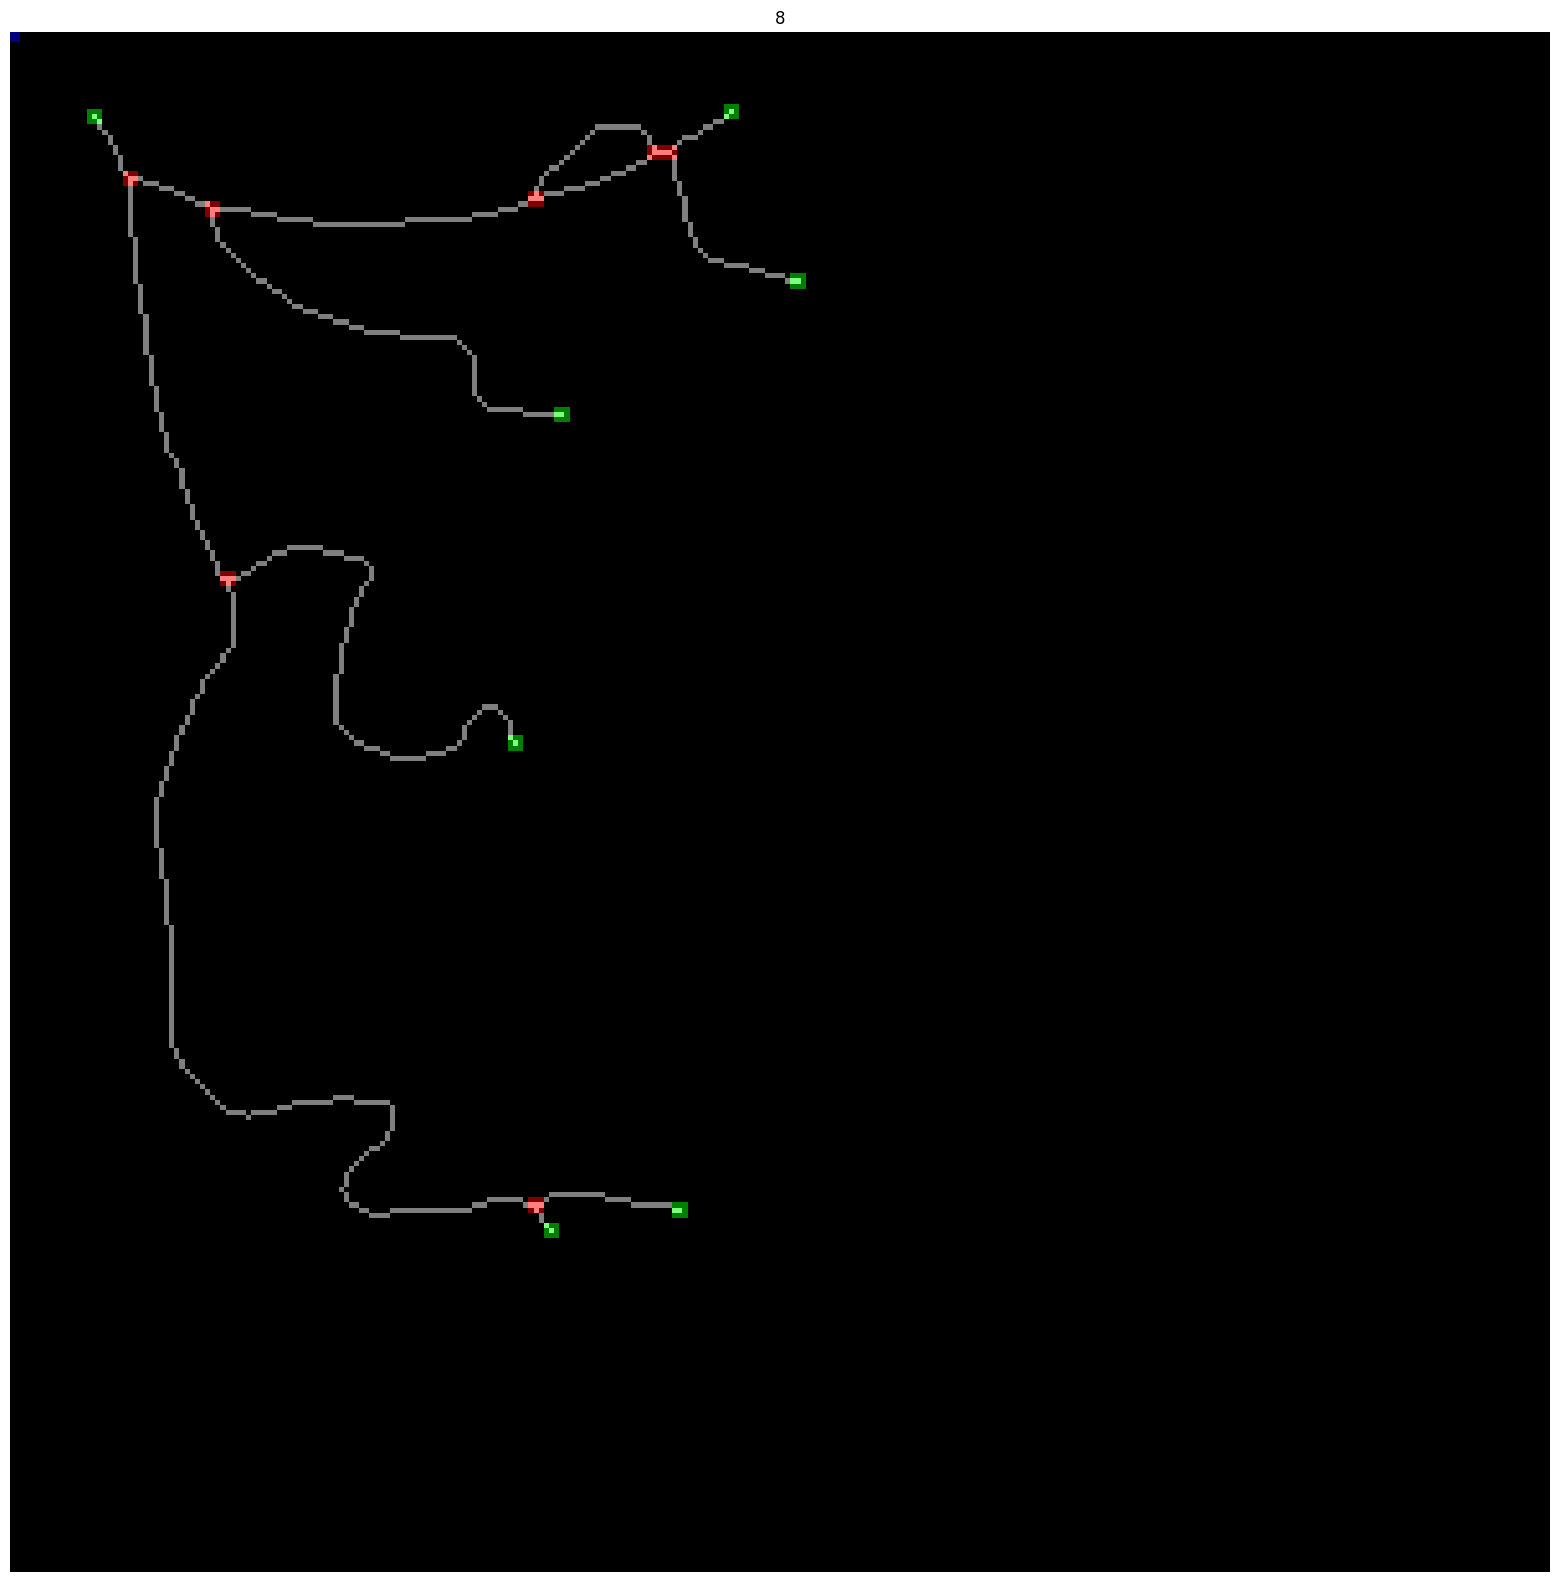

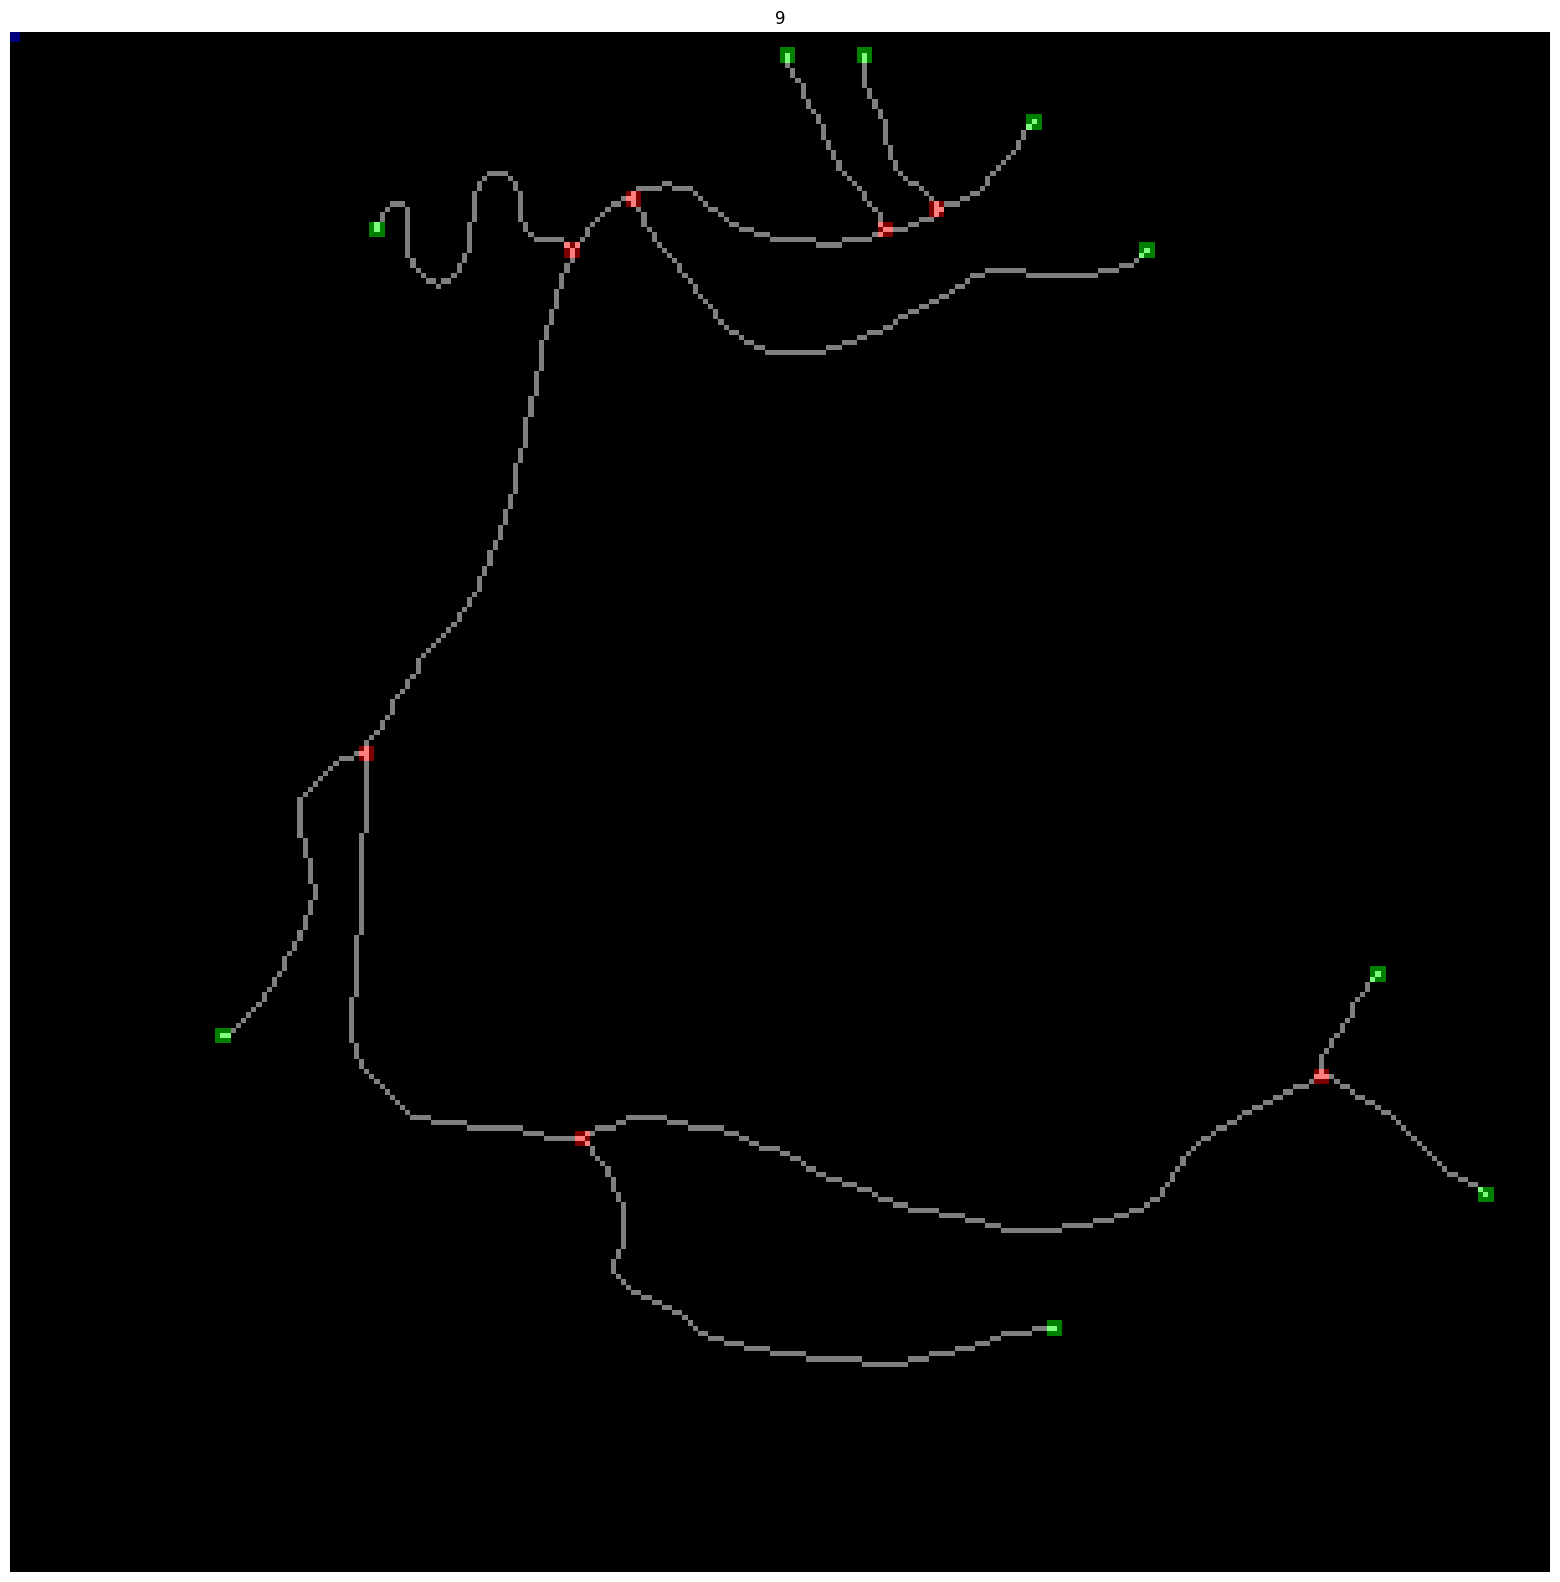

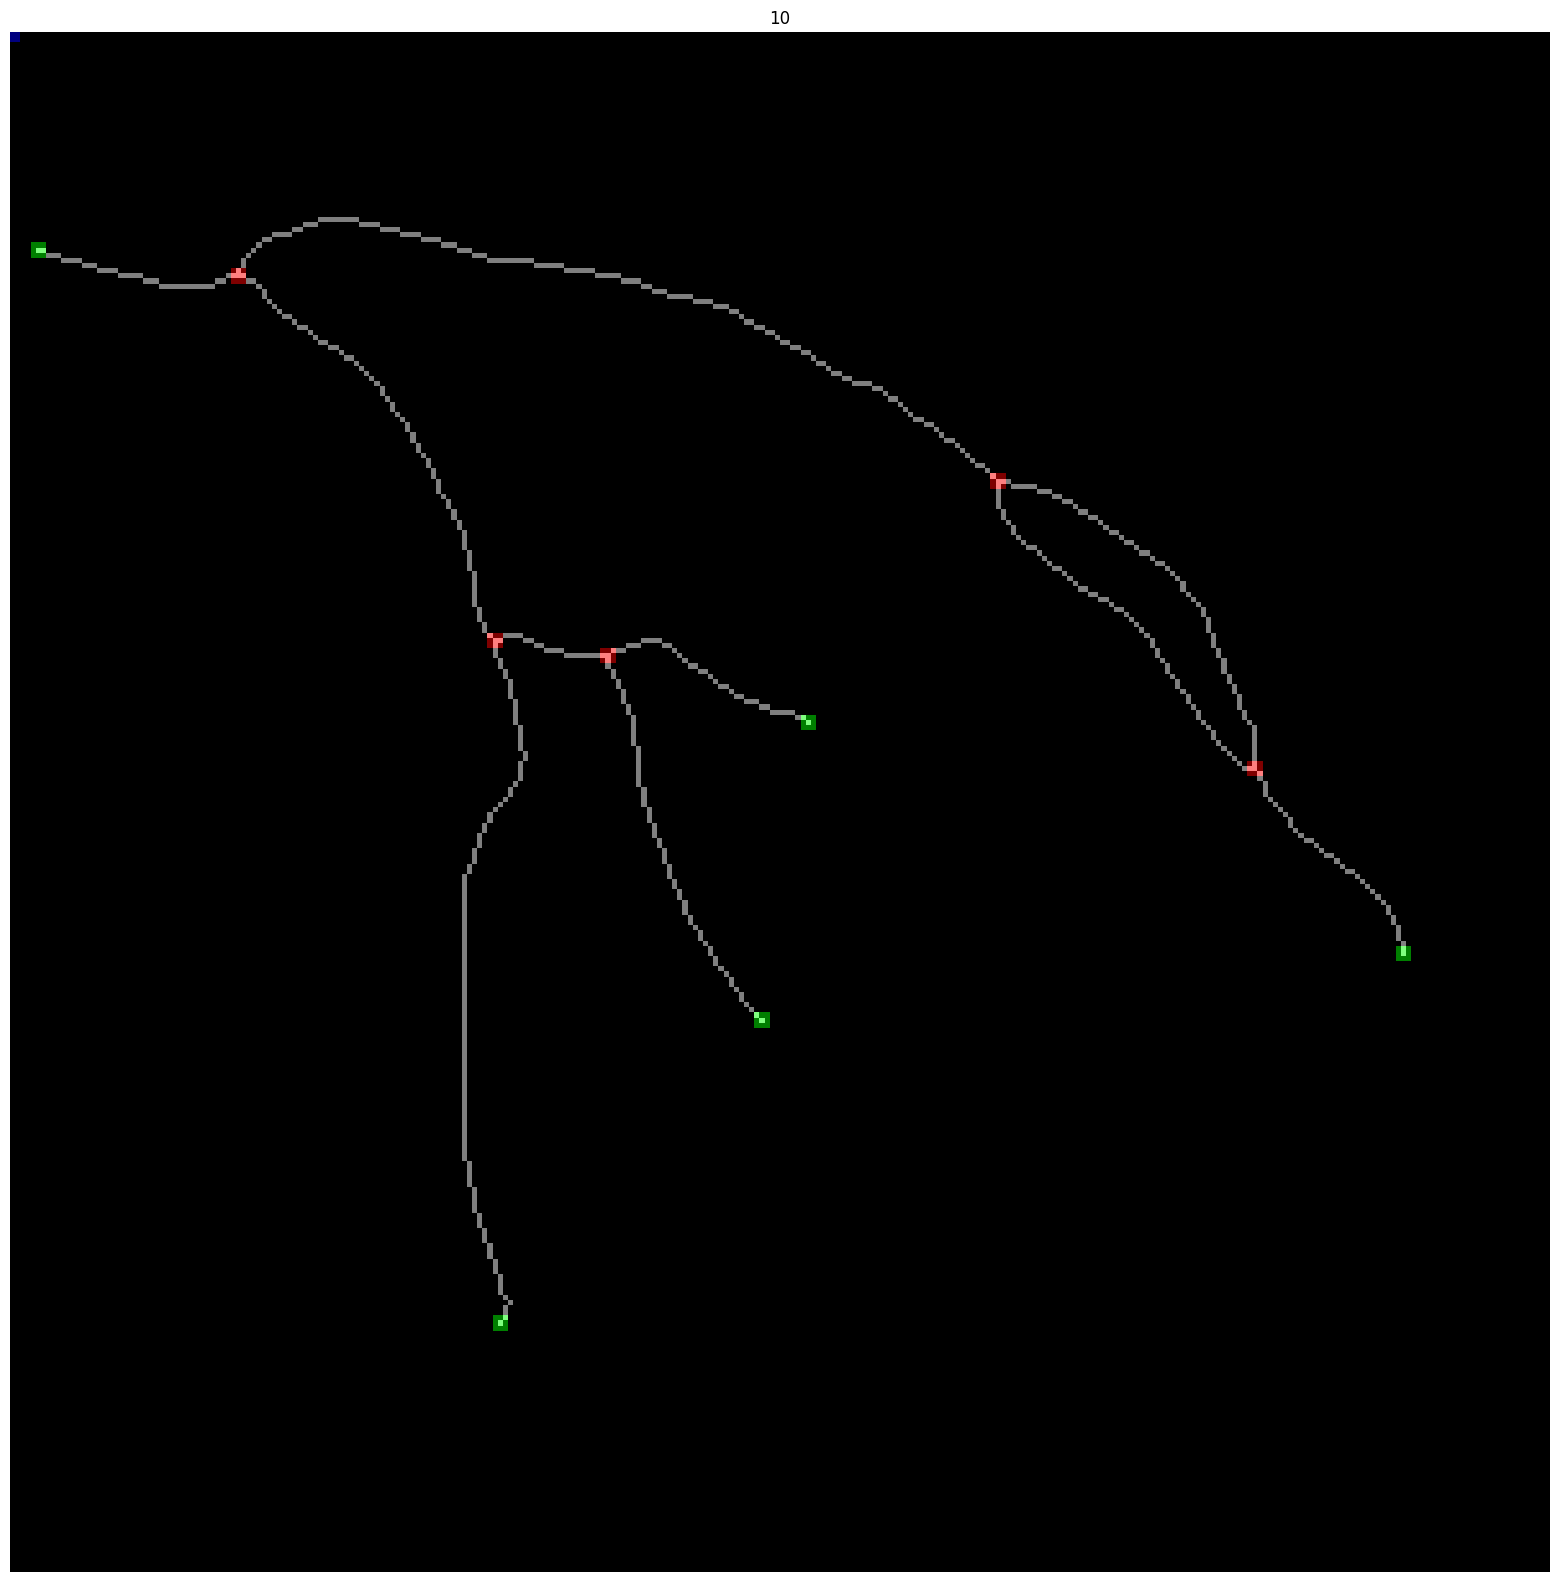

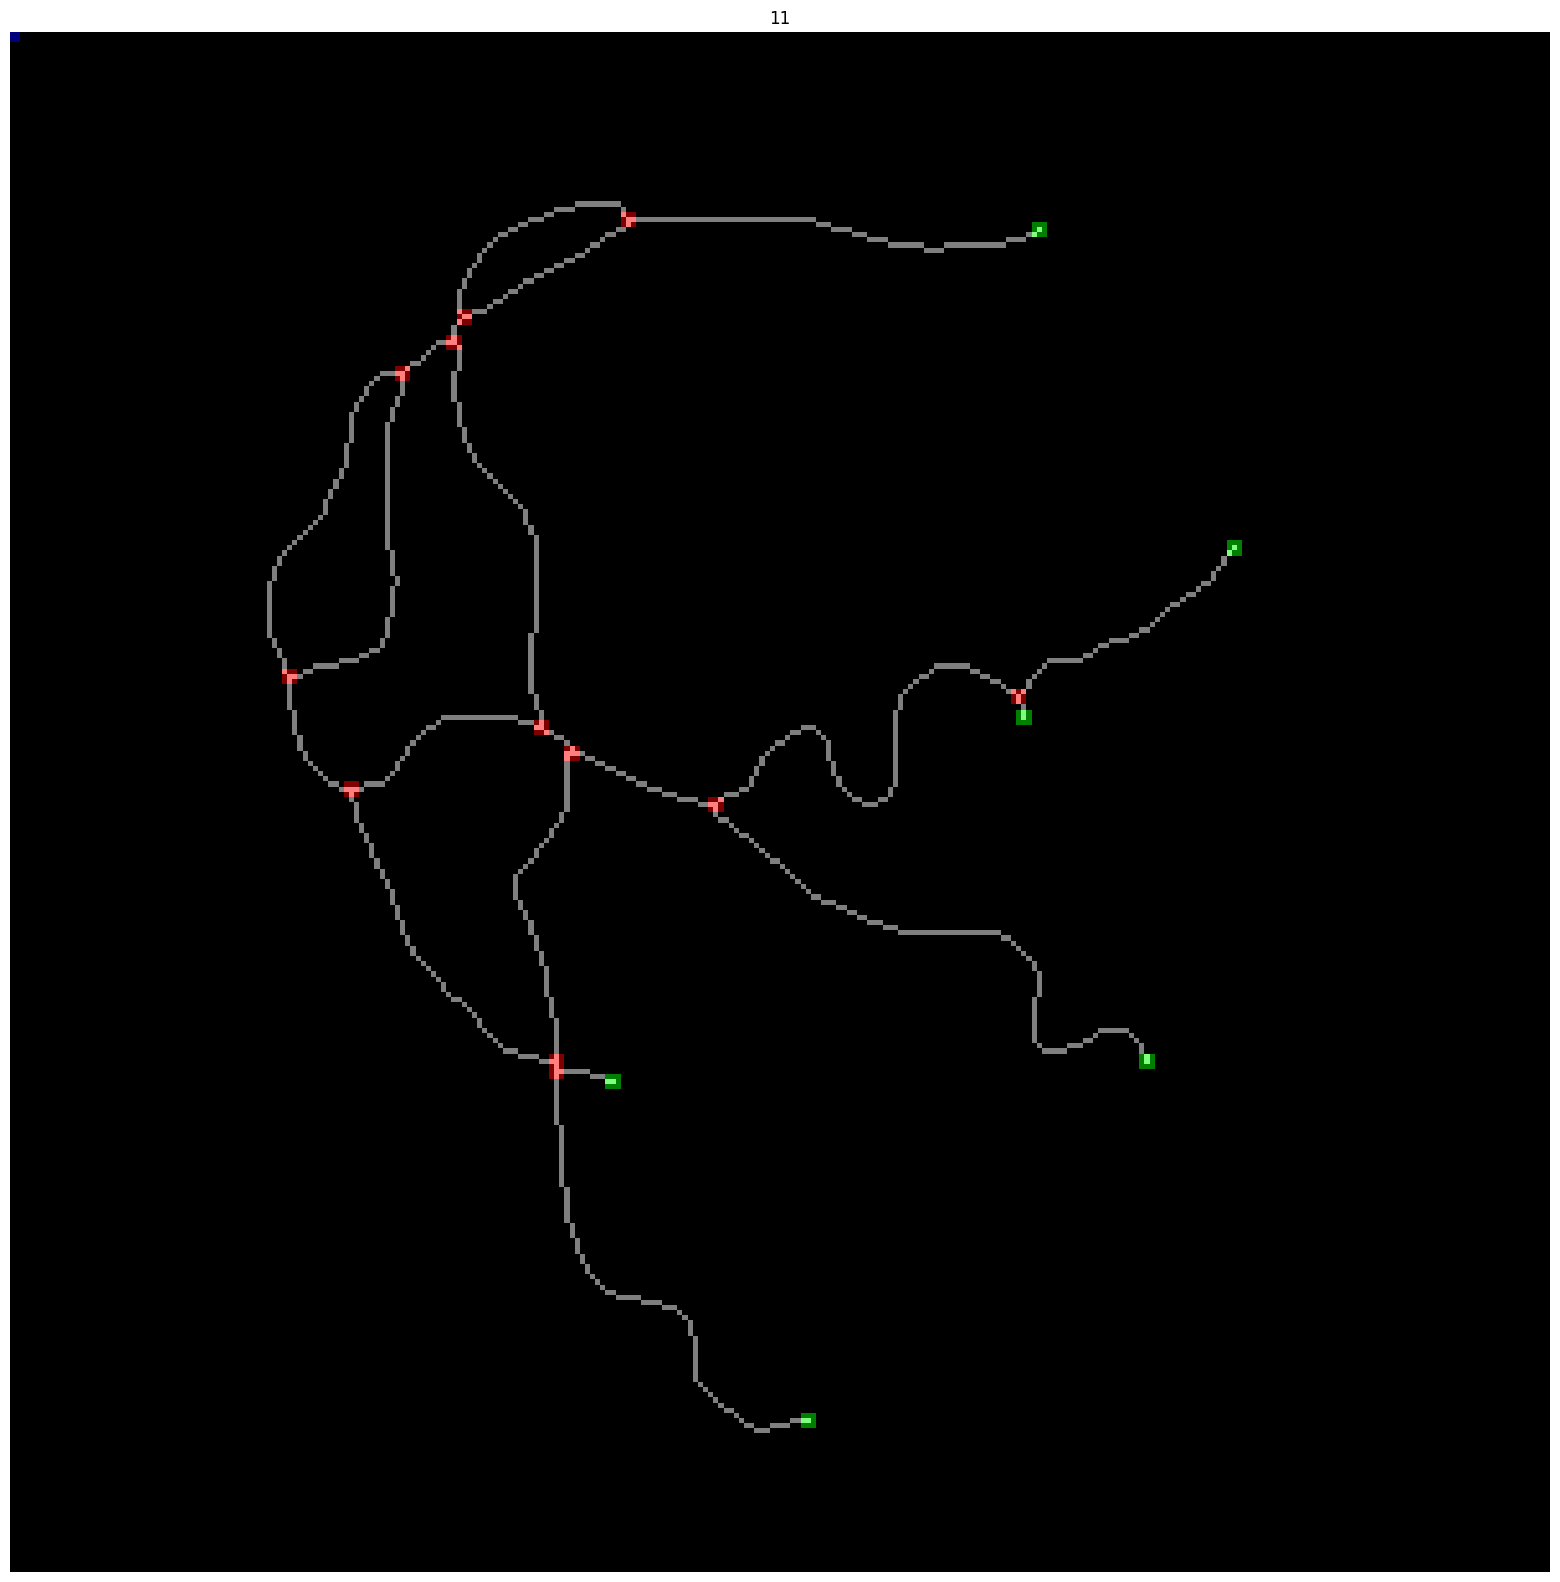

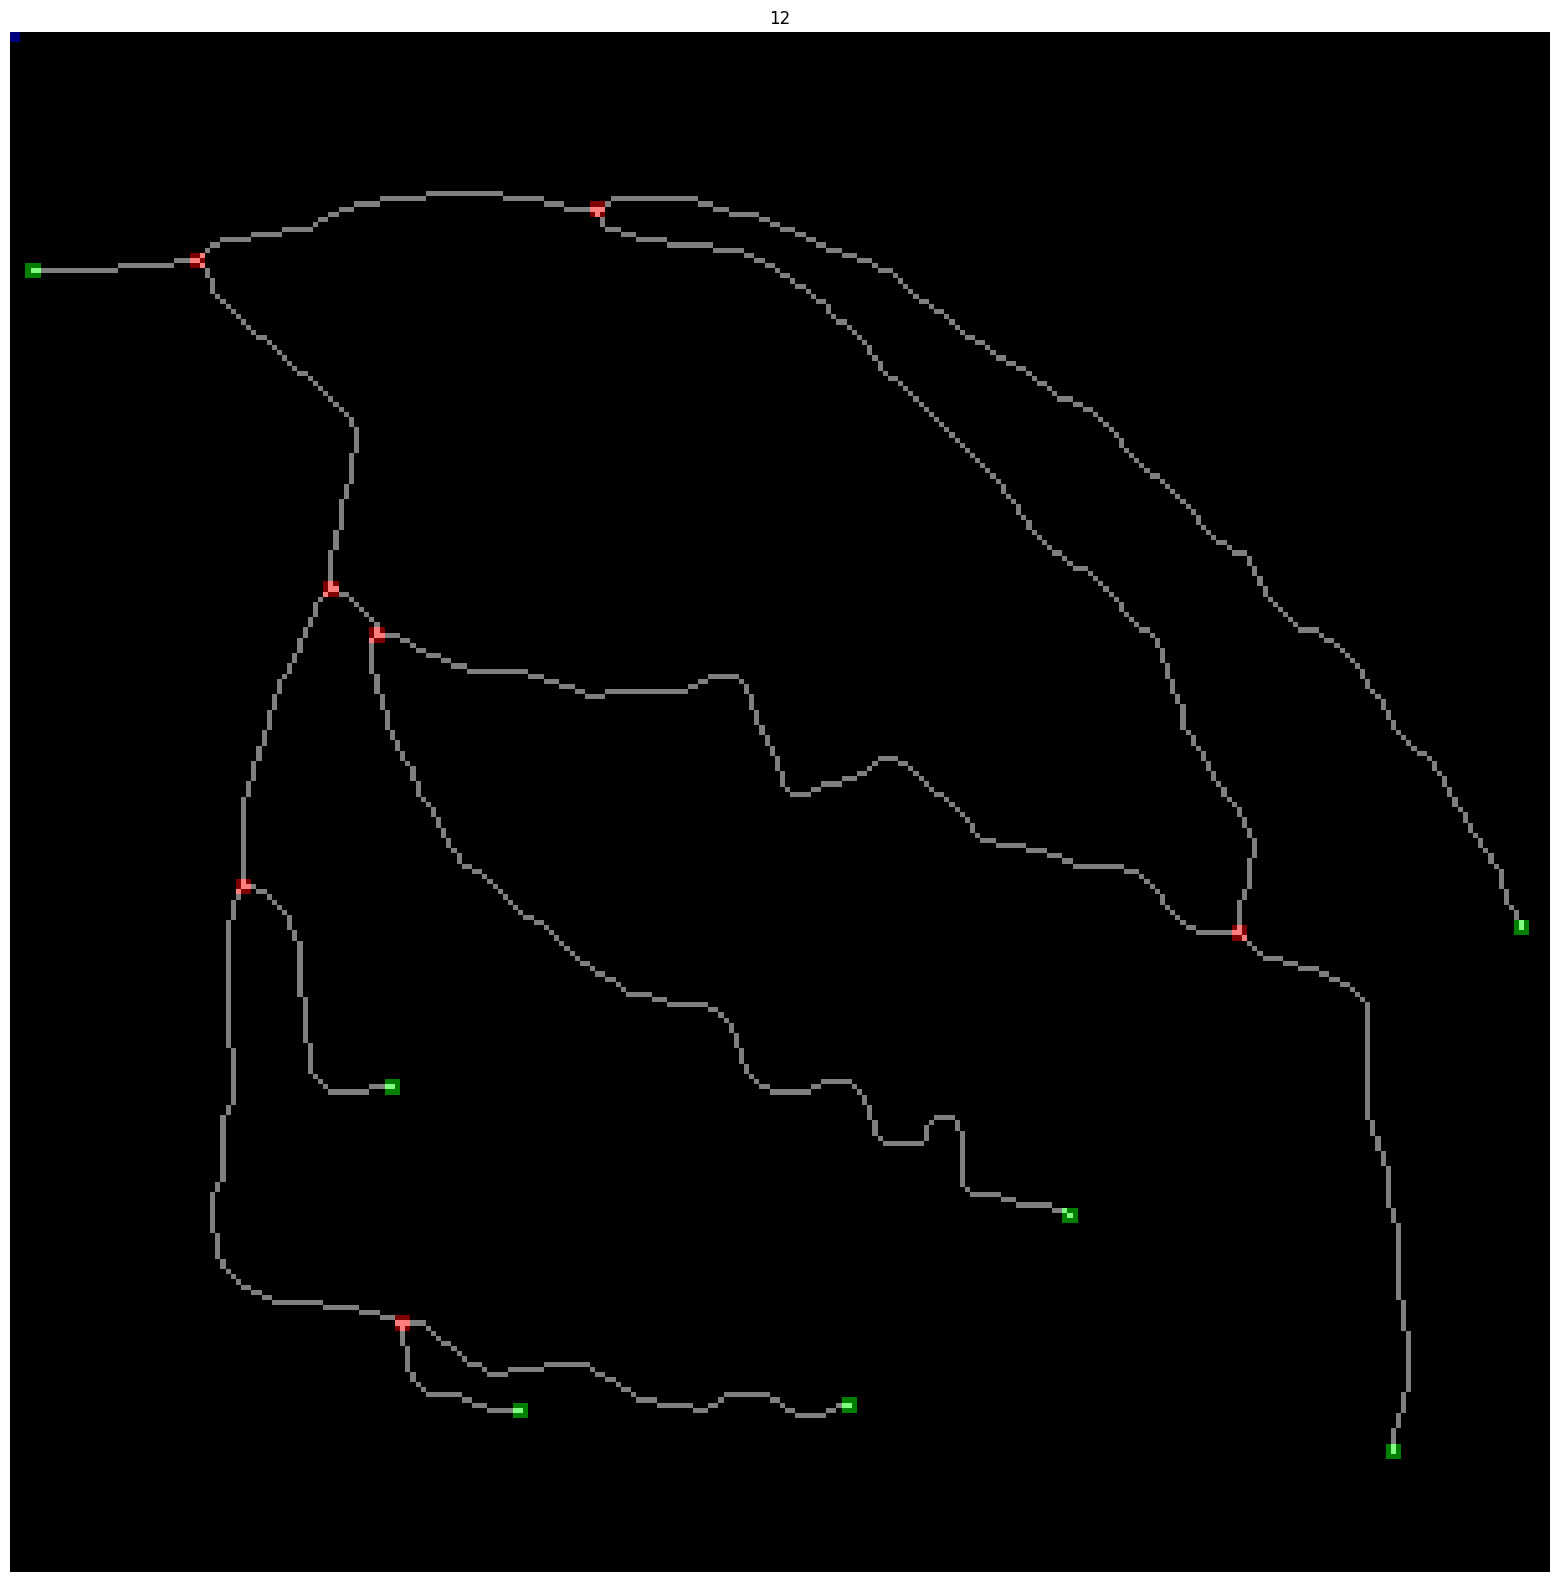

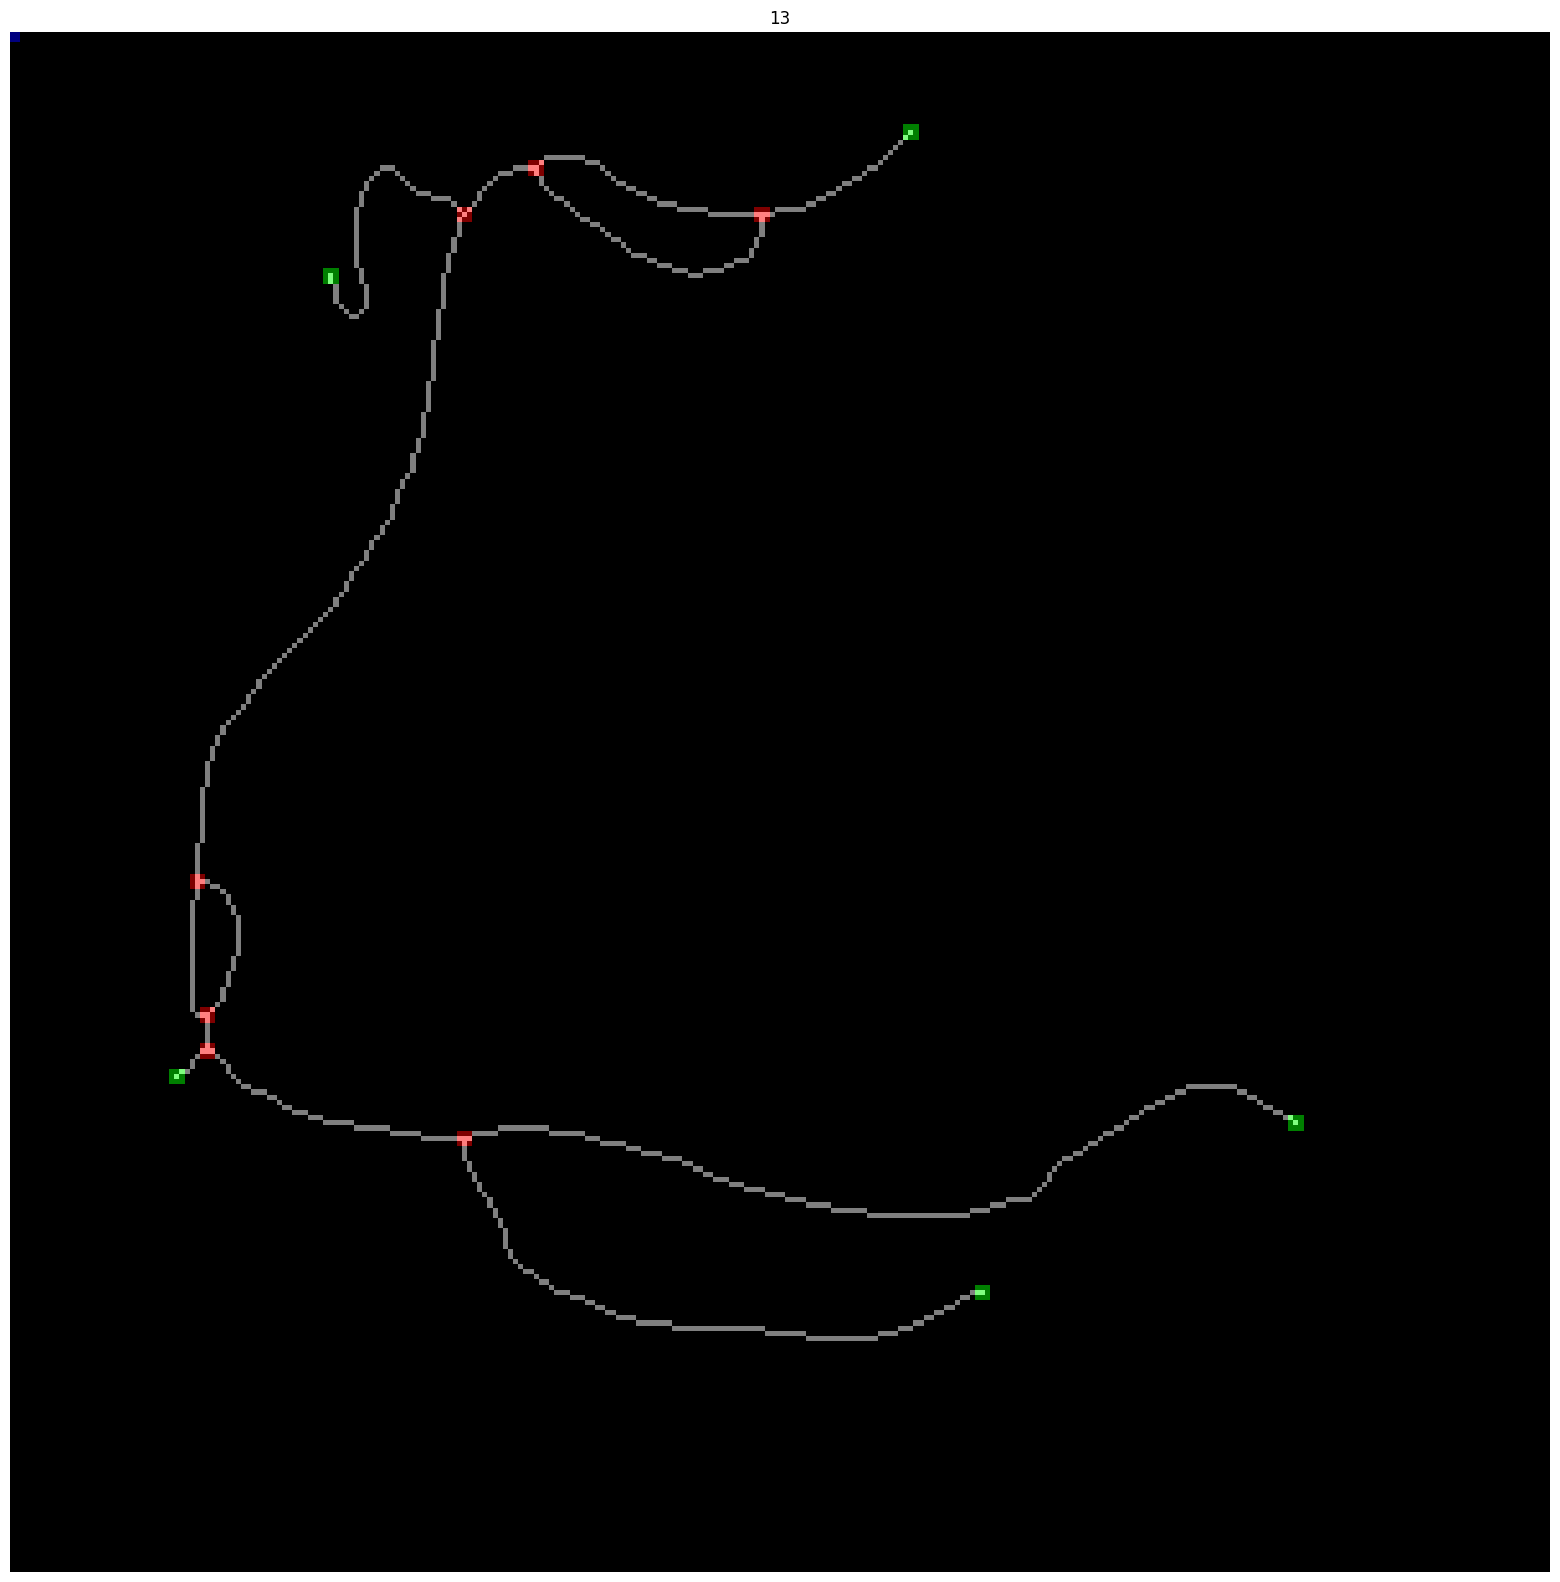

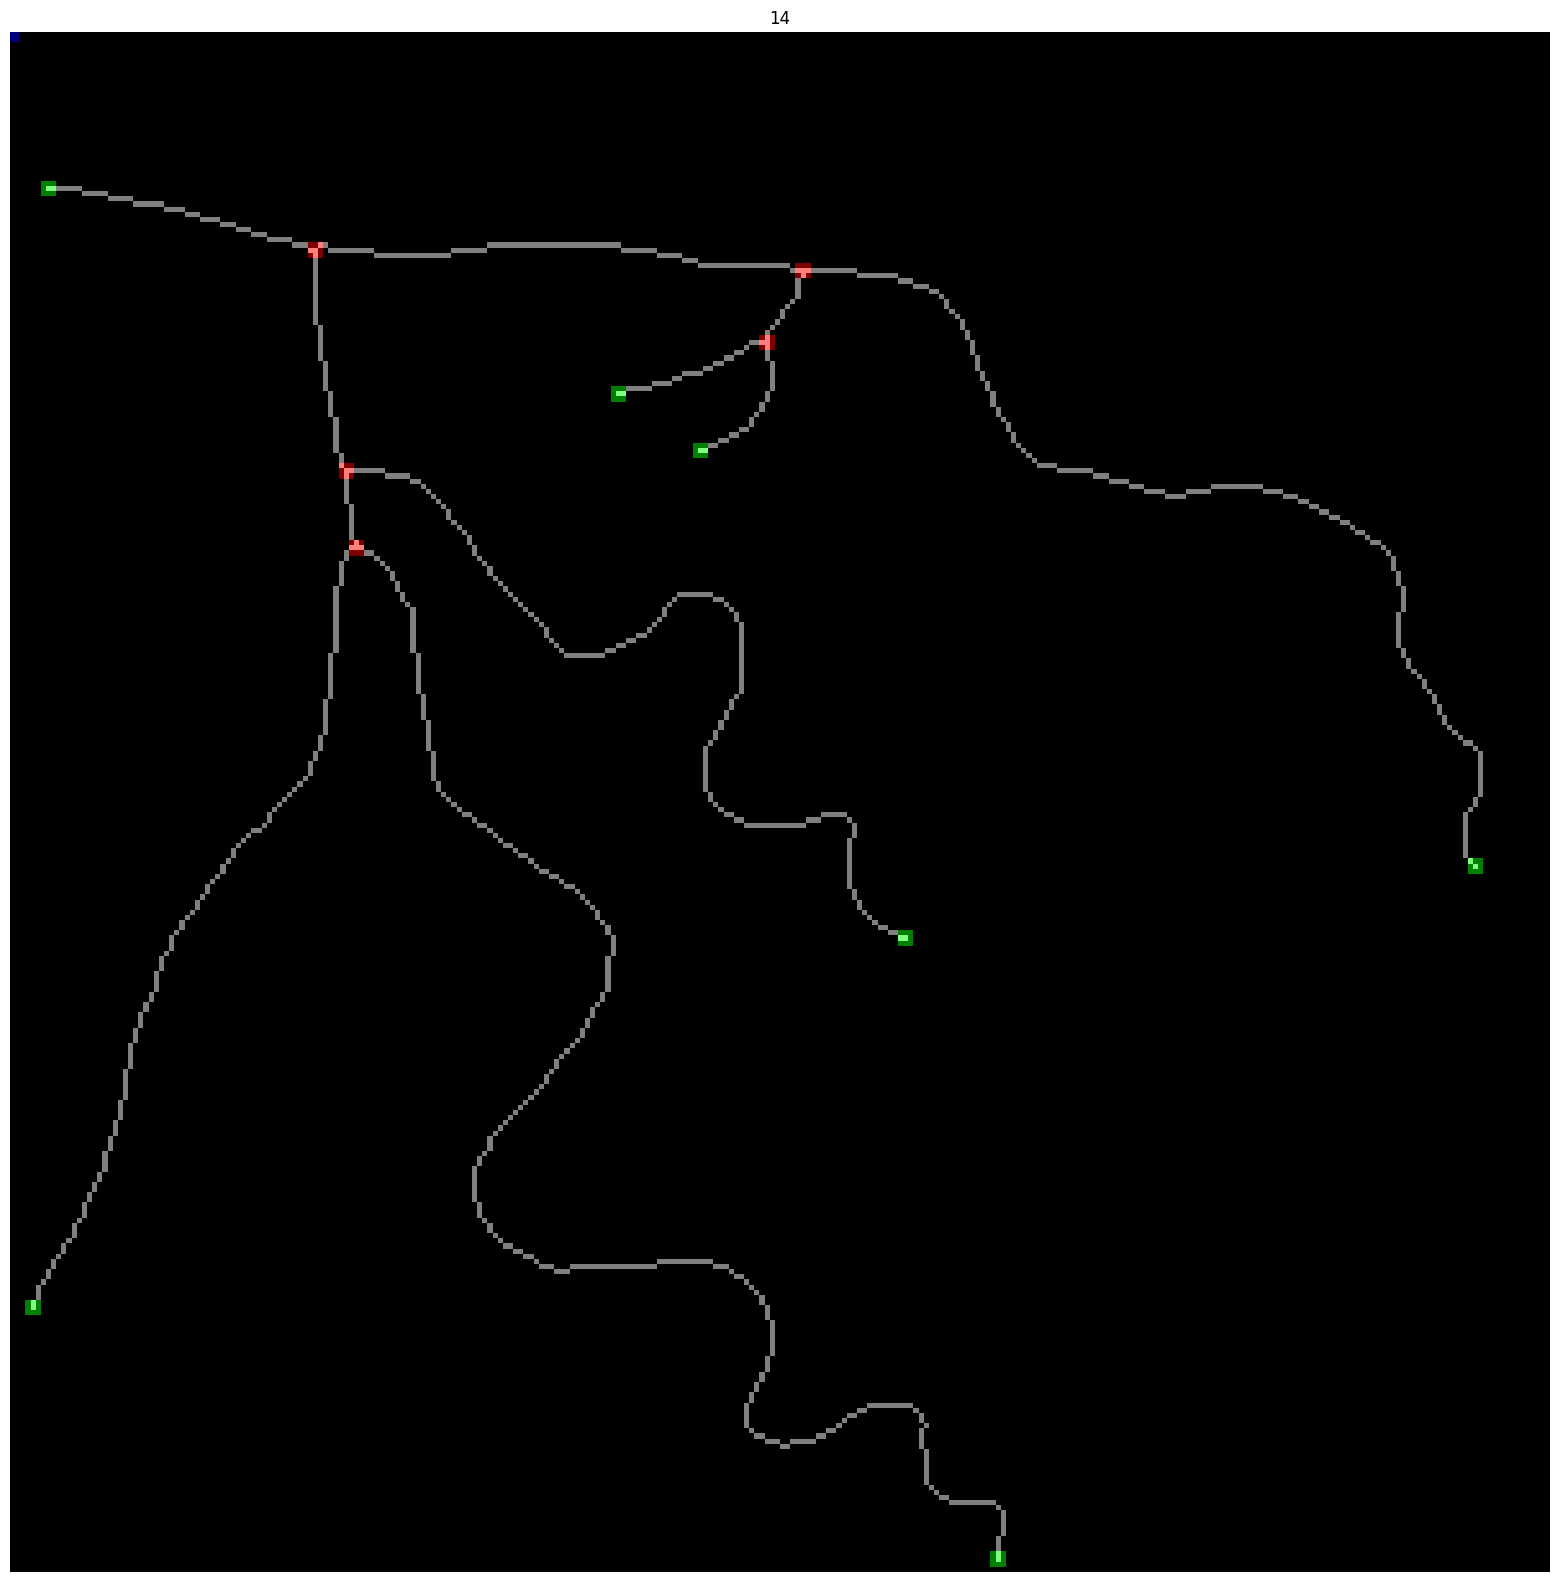

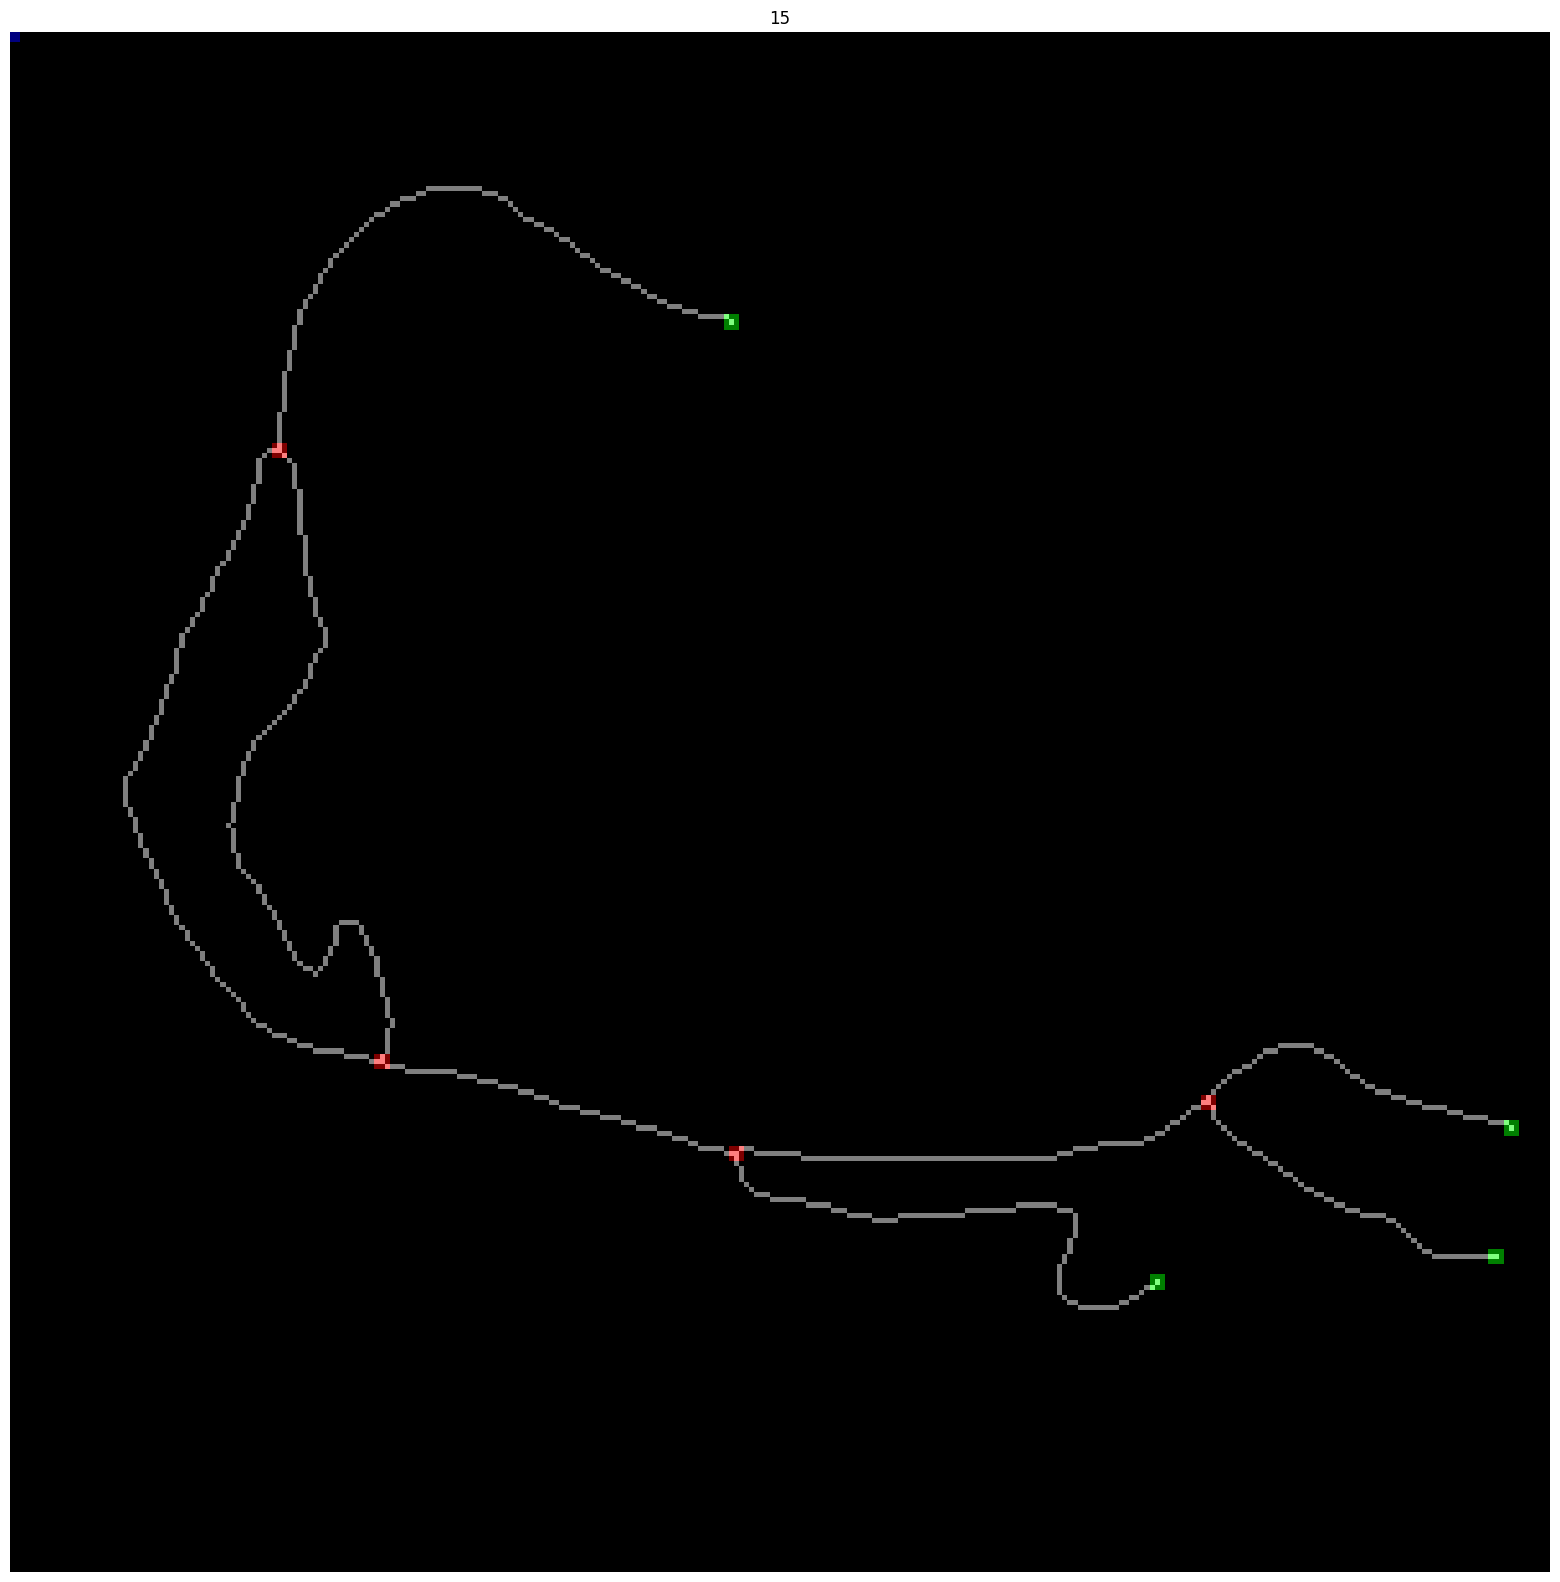

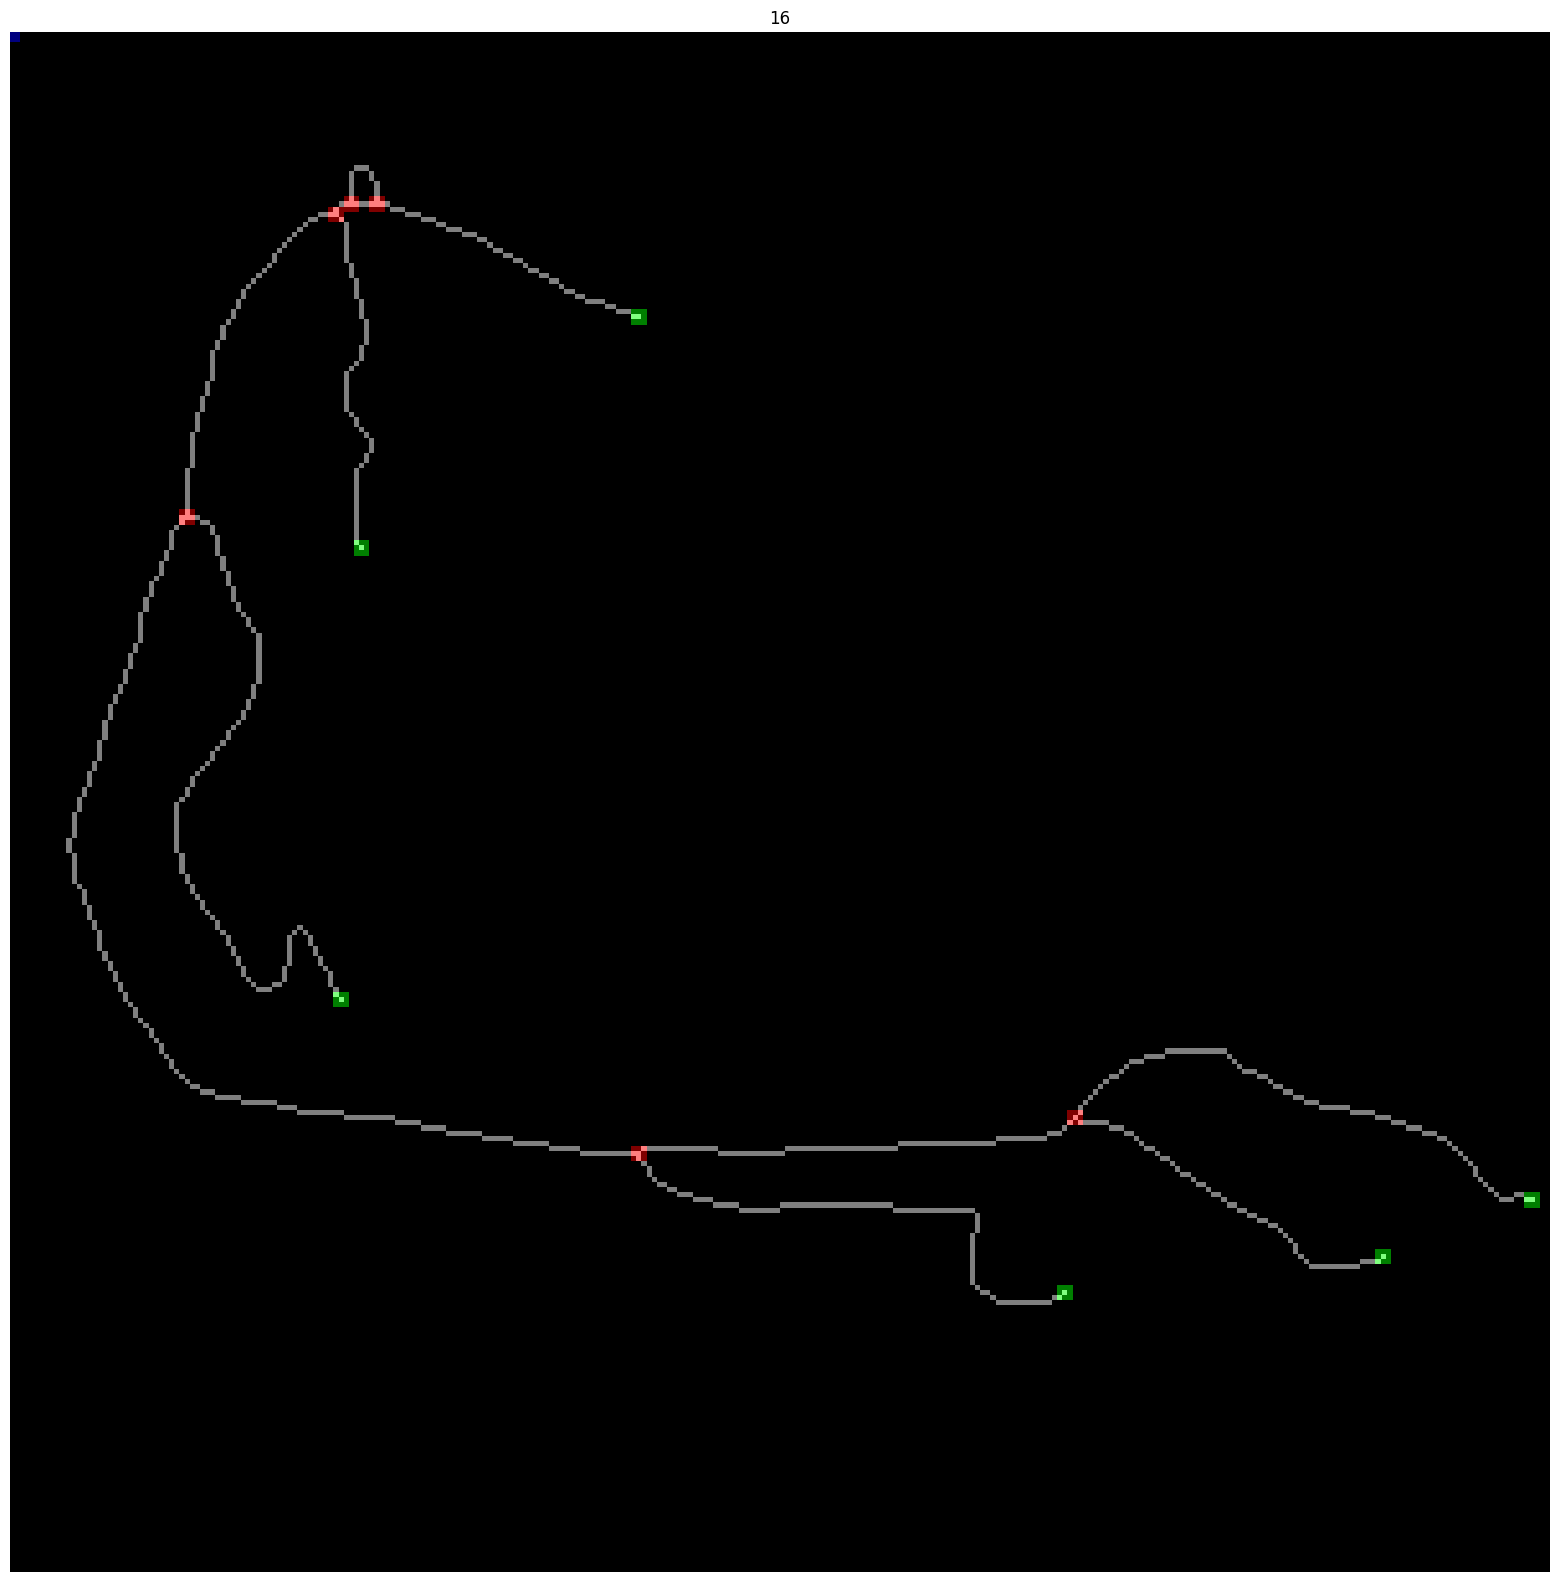

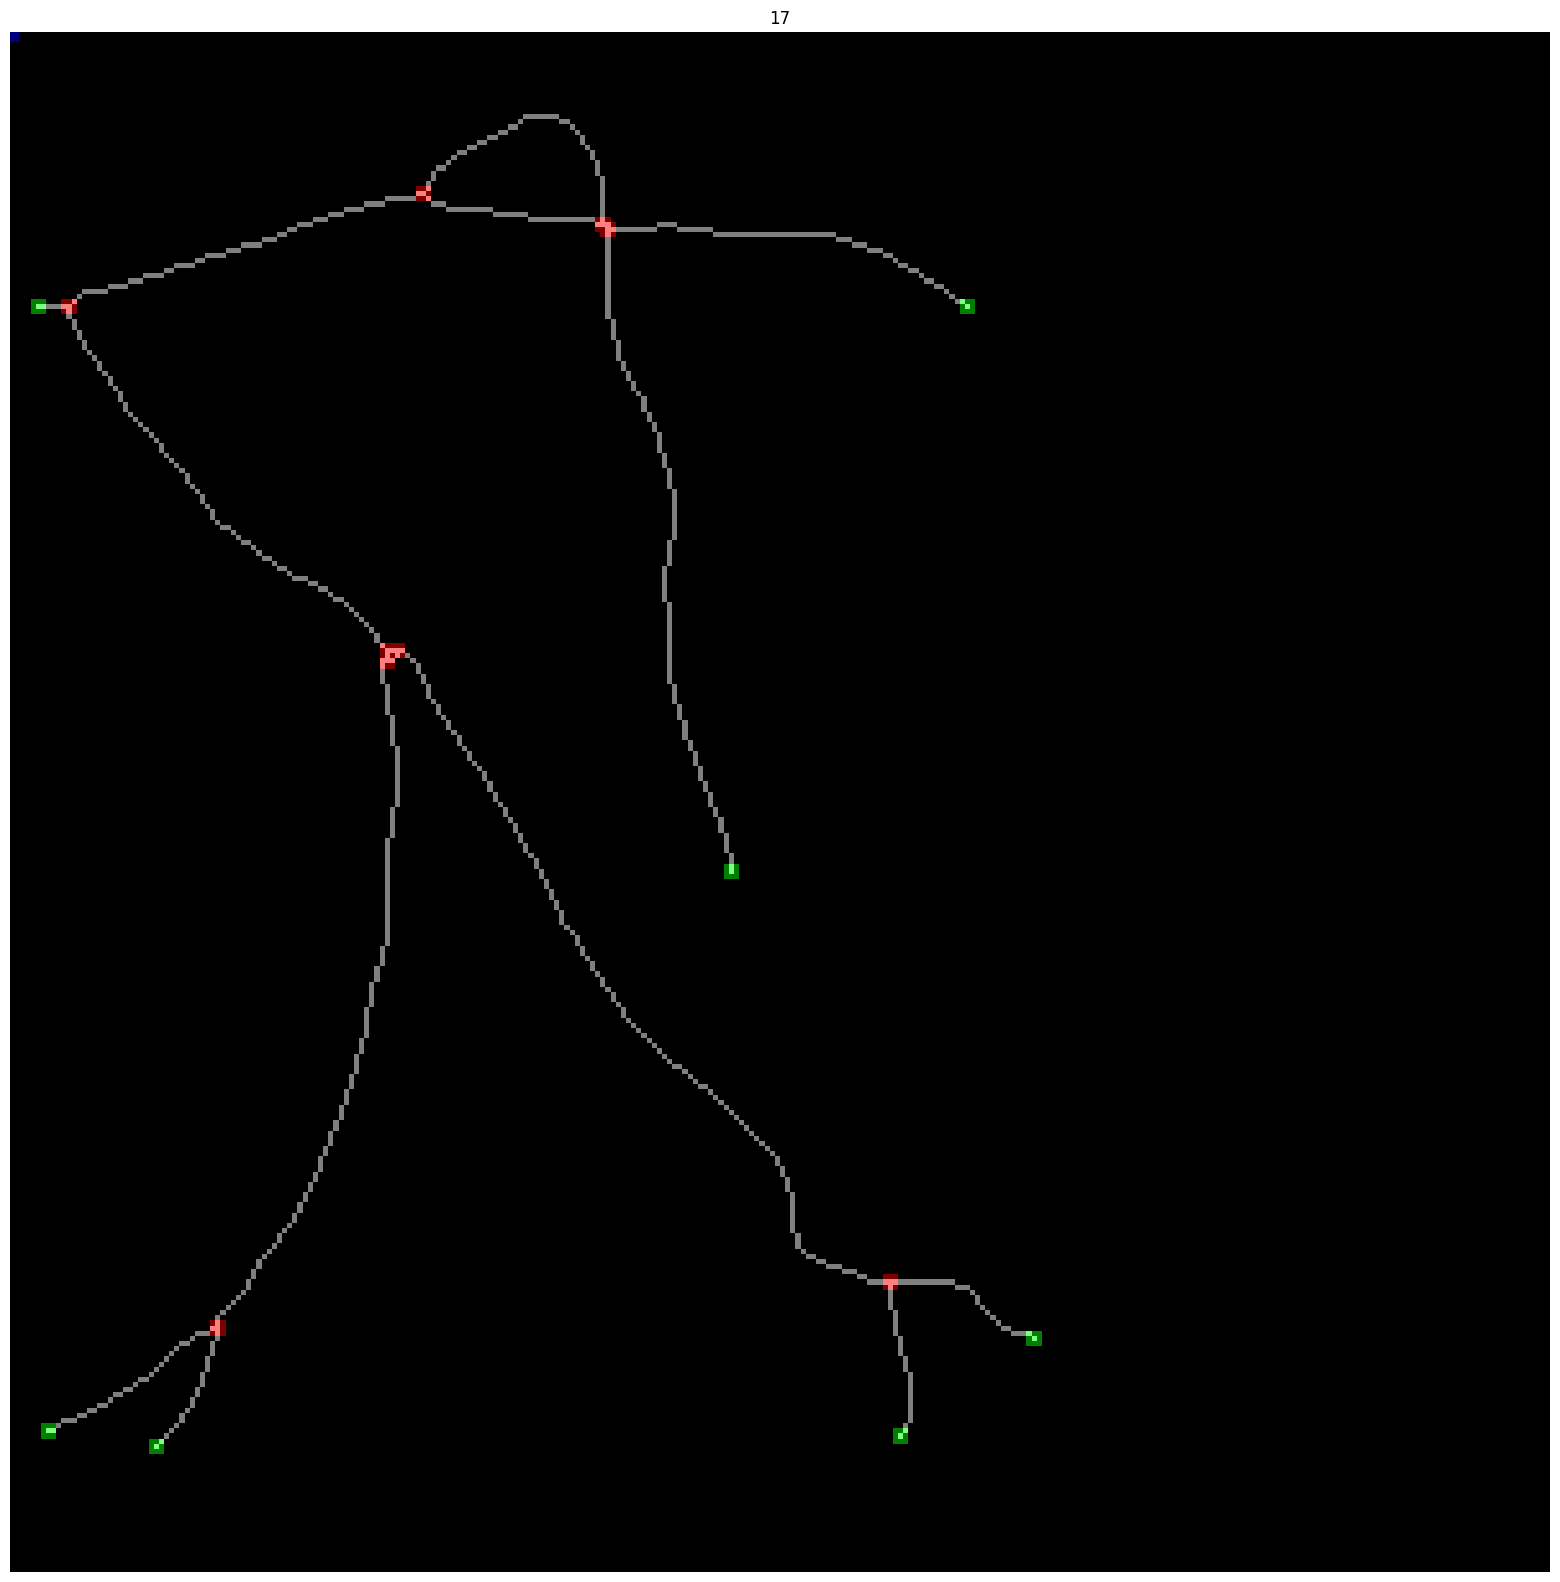

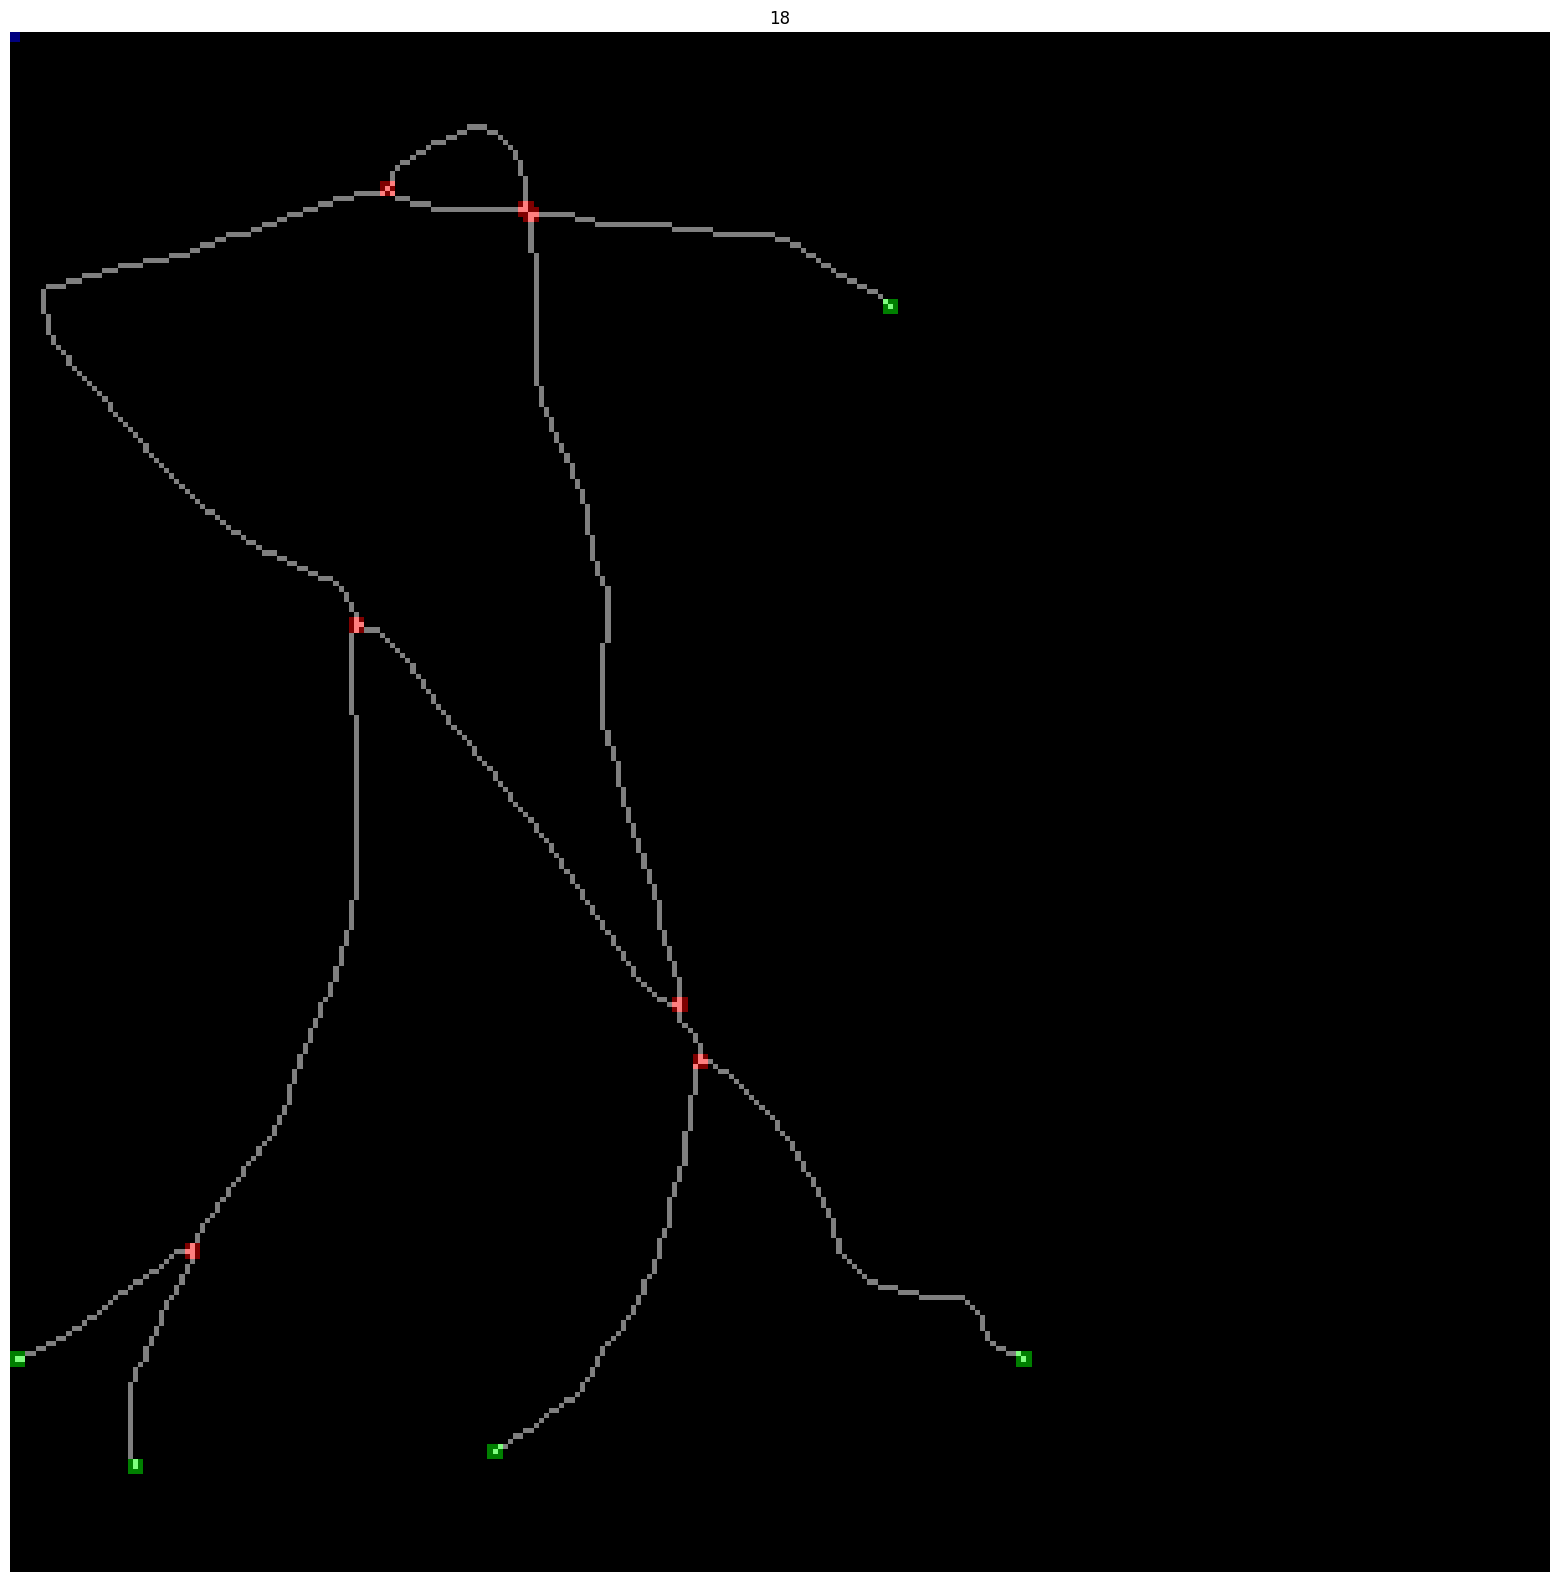

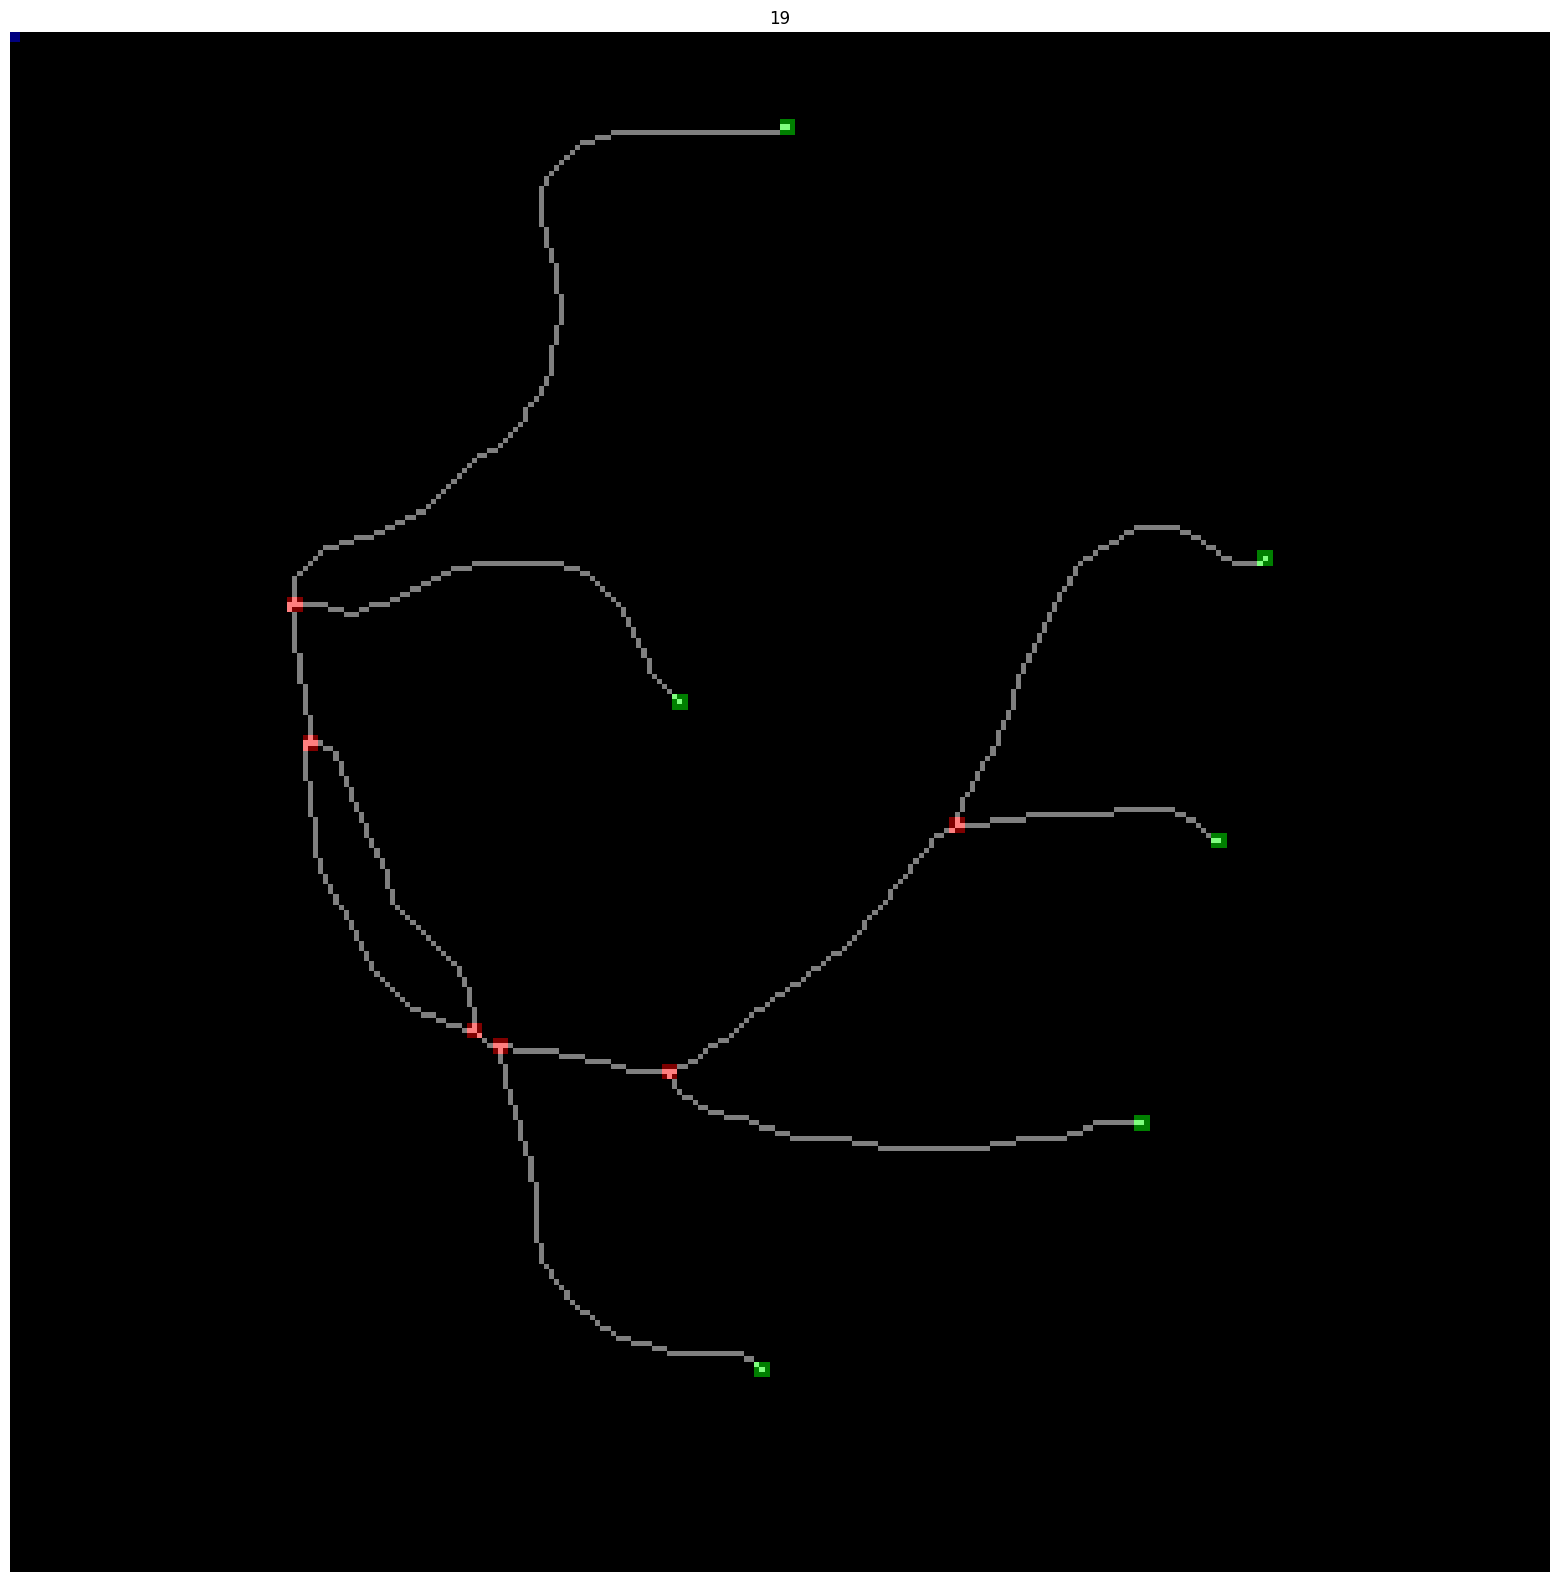

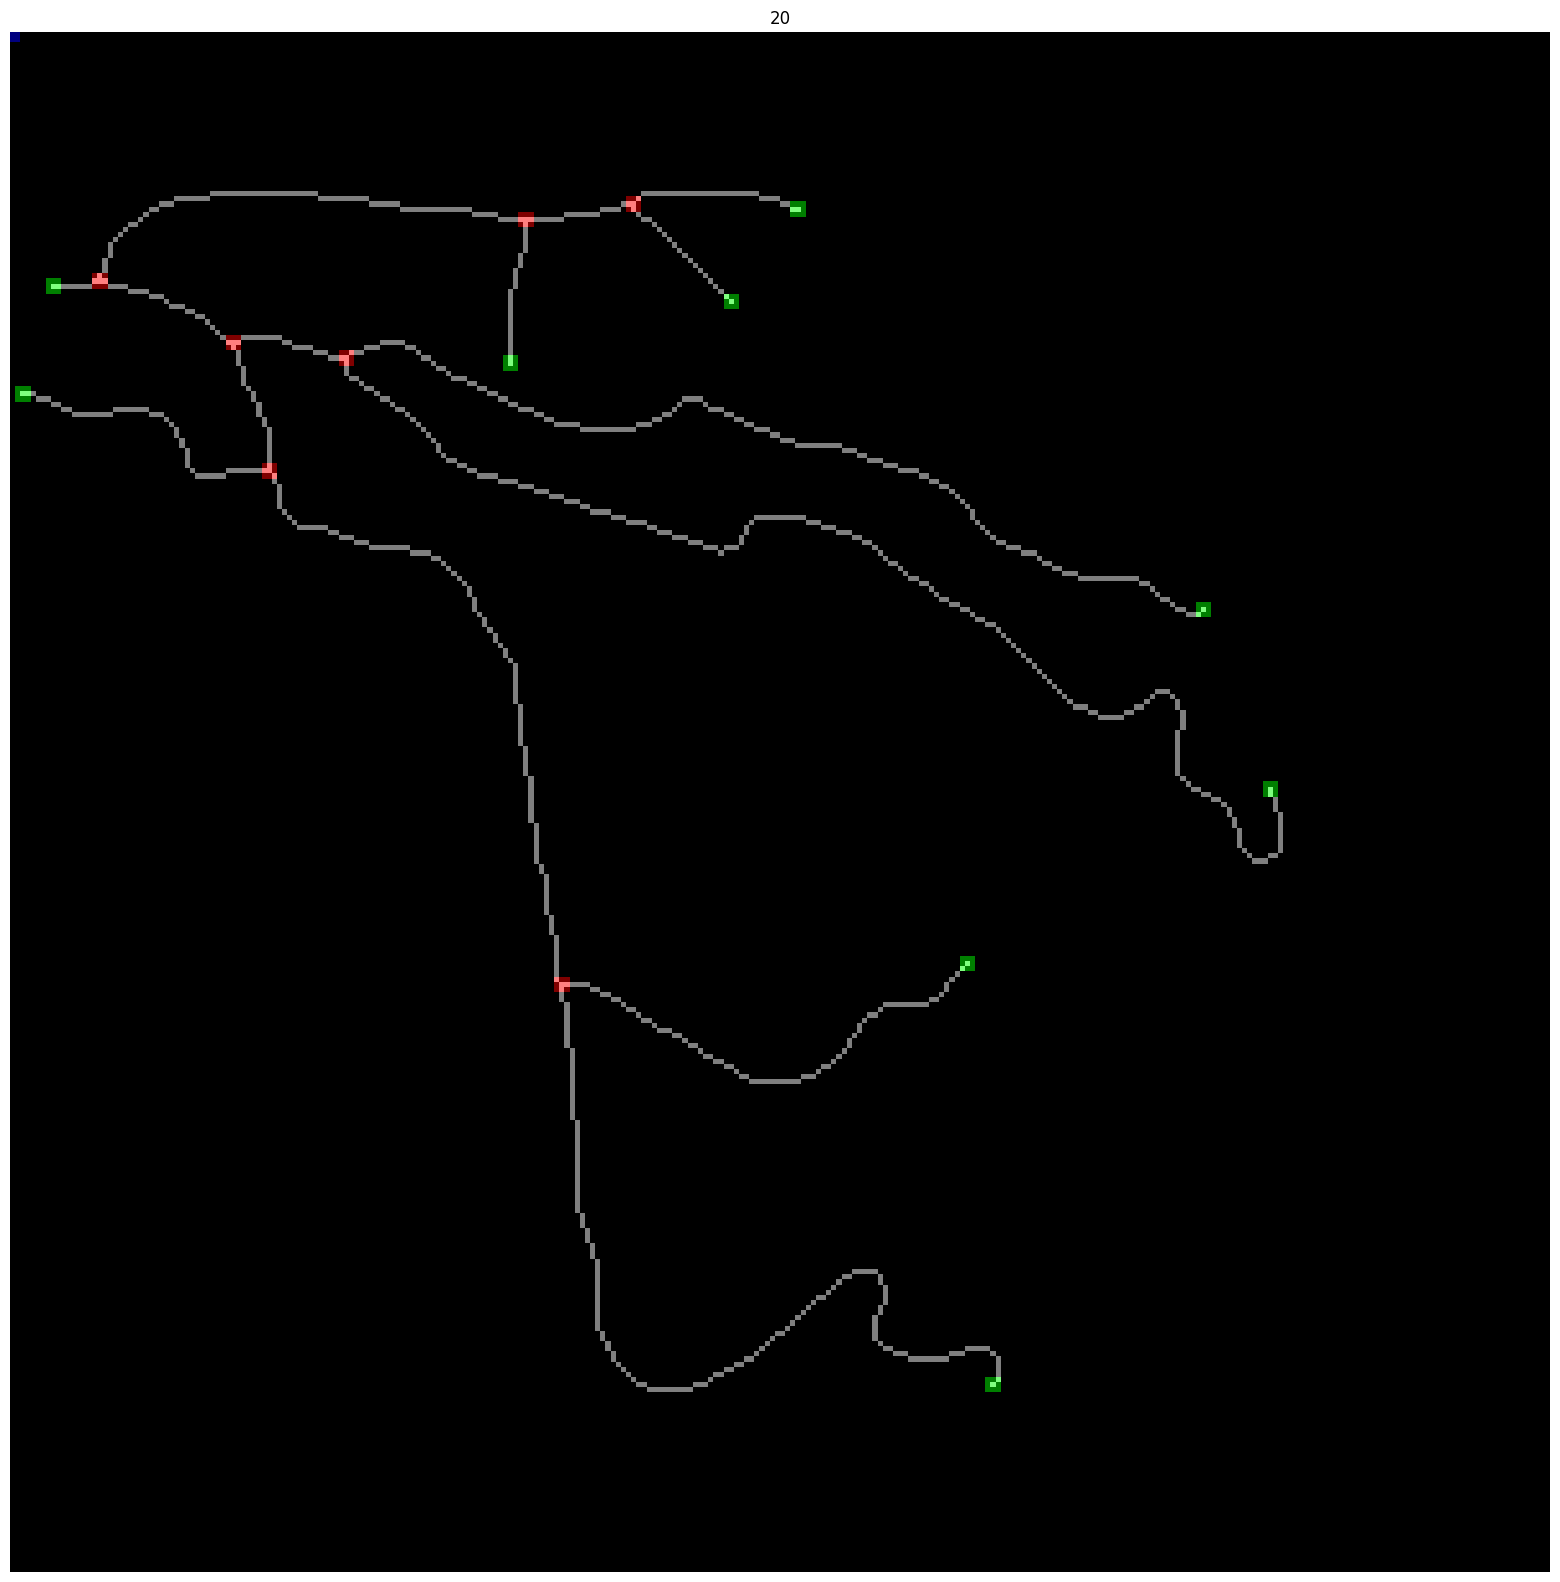

In [7]:
for i in range(1,21):
    I = plt.imread(f'./{i}_gt.pgm')
    I = I/255
    #I = (ski.color.rgb2gray(I* 255)).astype(np.uint8)
    T = skeletonize(I)
    # Supongamos que R, G y B son imágenes en escala de grises con el mismo tamaño
    R0 = detector(T,S1) + detector(T,S2) + detector(T,S3) + detector(T,S4) # Canal Rojo
    G0 = detector(T,S1f) + detector(T,S2f)    # Canal Verde
    B0 = detector(T,S1t) + detector(T,S2t) + detector(T,S3t) + detector(T,S4t) + detector(T,S5t) # Canal Azul
    # colocar puntos
    R = mo.dilation(R0, se3) 
    G = mo.dilation(G0, se3) 
    B = mo.dilation(B0, se3) 
    # Normalizar a rango [0,1] si es necesario
    R = R / np.max(R)
    G = G / np.max(G)
    #B = B / np.max(B)
    if np.max(B) > 1:
        B = B / np.max(B)
    R = (R+T) /2
    G = (G+T) /2
    B = (B+T) /2
    # Combinar los 3 canales en una imagen RGB
    RGB_image = np.stack((R, G, B), axis=-1)  # Shape: (100, 100, 3)
    
    # Mostrar la imagen resultante
    plt.figure(figsize=(20,20))
    plt.title(i)
    plt.imshow(RGB_image)
    plt.axis("off")  # Ocultar ejes
    plt.show()